### Prediction of  Processing Time and Average Power Consumption of CNC Milling Machine

#### Import Required Library

In [313]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.exceptions import ConvergenceWarning

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

#### Configure plot global parameters

In [4]:
# set parameters of plots
plt.rcParams['figure.figsize'] = (30,7)
plt.rcParams['font.size'] = 25
plt.rcParams['axes.titlepad'] = 30 
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20

#### Load Data Set

In [17]:
df = pd.read_excel('CNC_MillingMachine_production_data.xlsx')
df.head()

,start_time,end_time,processing_time,average_power_consumption,number_of_missing_datapoints,raw_volume,number_of_lines_of_code,number_tool_changes,number_of_travels_to_machine_zero_point_in_rapid_traverse,number_axis_rotations,weighted_speed,weighted_tool_diameter,weighted_cutting_length,weighted_number_of_cutting_edges,weighted_cutting_speed,weighted_feed_per_tooth,weighted_feedrate
0,1649055030,1649055950,920,23582271739130432,0,136659600,5809,5,11,6,79438718501135840,15894074969770256,4343264812575575,4010019001554673,3977633442736224,11971497667991020,36788711932266936
1,1649056780,1649057100,320,25380875,0,136659600,462,4,13,7,78655669160619040,1148868778280543,28009049773755656,4208144796380091,28494117647058824,5610369532428357,182943409943081
2,1649237400,1649237800,400,26181281407035176,10,420000,234,2,5,3,7269291649018721,12126168224299066,5289719626168225,4107476635514018,1584158878504673,7263715661992795,20428703826796160
3,1649243450,1649243800,350,3386402857142857,0,420000,234,2,5,3,7269291649018721,12126168224299066,5289719626168225,4107476635514018,1584158878504673,7263715661992795,20428703826796160
4,1649243850,1649244200,350,3306637142857143,0,420000,234,2,5,3,7269291649018721,12126168224299066,5289719626168225,4107476635514018,1584158878504673,7263715661992795,20428703826796160


#### Display formation about the features

In [18]:
df.shape

(220, 17)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 17 columns):
 #   Column                                                     Non-Null Count  Dtype
---  ------                                                     --------------  -----
 0   start_time                                                 220 non-null    int64
 1   end_time                                                   220 non-null    int64
 2   processing_time                                            220 non-null    int64
 3   average_power_consumption                                  220 non-null    int64
 4   number_of_missing_datapoints                               220 non-null    int64
 5   raw_volume                                                 220 non-null    int64
 6   number_of_lines_of_code                                    220 non-null    int64
 7   number_tool_changes                                        220 non-null    int64
 8   number_of_travels_to_machine_z

- There are 220 records with 17 features
- There are no missing values for each of the dataset
- All features are of type int64

Description of the features in the dataset:
    
1. **start_time**:  process start time in UTC.
2. **end_time**: when process finish in UTC.
3. **processing_time**: The difference between the endtime and start_time. It indicates the duration of the process [in seconds].
4. **average_power_consumption**: average power consumption during the process [Watt].
5. **number_of_missing_datapoints**: It indicates the Number of missing power measurement points during the process The power data is collected with 1 minute interval.
6. **raw_volume**: volume of the processed material [mm3].
7. **number_of_lines_of_code**: the number of lines of G/NC code that execute the process
8. **number_tool_changes**: the umber of tool changes during the process, e.g. drill head -> milling head or larger drill head -> smaller drill head. It does not refer to replacement through wear, just different tools for different tasks.
9. **number_of_travels_to_machine_zero_point_in_rapid_traverse**: the number of travels/movements of the tools from the initial state (zero point of the machine’s coordinate system) to rapid repetitive/traverse process.
10. **number_axis_rotations**: This indicates the Number of changes in the position of the axis of rotation of the tool (e.g. drill head).
11. **weighted_speed**: rotation speed of the tool, e.g. drill head [1/min]
12. **weighted_tool_diameter**: the Diameter of the tool used for a production step [mm].
13. **weighted_cutting_length**: the Length of the cutting edges of the tool used for a production step [mm].
14. **weighted_number_of_cutting_edges**: number of cutting edges of the tool used for a production step.
15. **weighted_cutting_speed**: Speed at which the cutting edge of the tool used for a production step cuts into the material [m/s].
16. **weighted_feed_per_tooth** : the portion of distance during feed into the component per cutting tooth of the tool used for a production step per revolution [mm].
17. **weighted_feedrate**: the speed at which the tool cuts through/into the material in [mm/min].

**Target Features**
- processing_time
- average_power_consumption

In [14]:
# drop columns
df.drop(columns=['start_time', 'end_time'], inplace=True)

Further optimisation of the dataset can be carried out based on the findings of the exploratory data analysis, carried out in the next section.

#### Summary Statistics

In [25]:
df.describe()

,start_time,end_time,processing_time,average_power_consumption,number_of_missing_datapoints,raw_volume,number_of_lines_of_code,number_tool_changes,number_of_travels_to_machine_zero_point_in_rapid_traverse,number_axis_rotations,weighted_speed,weighted_tool_diameter,weighted_cutting_length,weighted_number_of_cutting_edges,weighted_cutting_speed,weighted_feed_per_tooth,weighted_feedrate
count,2.200000e+02,2.200000e+02,220.000000,2.200000e+02,220.000000,2.200000e+02,220.000000,220.000000,220.000000,220.000000,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02,2.200000e+02
mean,1.654939e+09,1.654940e+09,1022.886364,1.662605e+16,19.272727,8.069418e+07,6895.327273,5.763636,48.781818,24.890909,9.168552e+15,1.110948e+16,1.964992e+16,1.020974e+16,1.211113e+16,1.232763e+16,1.098923e+16
std,2.215448e+06,2.215309e+06,1457.893633,1.396877e+16,33.765484,6.621539e+07,9597.106987,4.731952,72.534971,36.267486,1.029301e+16,5.188261e+15,1.418189e+16,1.395040e+16,1.445534e+16,1.390119e+16,1.048769e+16
min,1.649055e+09,1.649056e+09,100.000000,2.222300e+04,0.000000,2.492280e+05,86.000000,1.000000,3.000000,2.000000,1.098347e+14,8.000000e+01,2.000000e+02,2.000000e+01,4.000000e+02,4.700000e+01,1.829434e+14
25%,1.653306e+09,1.653307e+09,292.500000,2.316632e+15,0.000000,8.751360e+05,313.000000,2.000000,7.000000,4.000000,7.083711e+15,6.201614e+15,5.289720e+15,4.029052e+15,1.664277e+15,5.852345e+15,3.115166e+15
50%,1.656321e+09,1.656321e+09,480.000000,1.945973e+16,0.000000,1.366596e+08,968.500000,4.000000,21.000000,11.000000,7.779717e+15,1.212617e+16,2.229508e+16,4.154639e+15,2.800444e+15,8.155598e+15,4.428094e+15
75%,1.656419e+09,1.656420e+09,912.500000,2.972326e+16,20.000000,1.366596e+08,13447.000000,6.250000,63.000000,32.000000,8.008454e+15,1.550609e+16,2.851920e+16,5.646341e+15,2.117068e+16,1.390764e+16,2.042870e+16
max,1.657169e+09,1.657169e+09,6920.000000,4.229679e+16,210.000000,1.366596e+08,44441.000000,18.000000,263.000000,132.000000,7.943872e+16,1.913700e+16,4.210844e+16,4.894198e+16,3.964043e+16,5.852526e+16,3.678871e+16


From the above, we do not find evidence of invalid entries in our dataset.

---

#### Exploratory Data Analysis

#### define plot functions


**Distribution of the features**

In [132]:
def plot_histogram(data_frame, num_rows, num_cols):
    """plot histogram for features"""
    plt.figure(figsize=(35,35))
    for idx, col_name in enumerate(data_frame.columns):
        plt.subplot(num_rows, num_cols, idx + 1)
        sns.kdeplot(data=data_frame, x=col_name, fill=True)
    return None

def plot_boxplot(data_frame, num_rows, num_cols):
    """
    boxplot of features
    """
    plt.figure(figsize=(35,35))
    for idx, col_name in enumerate(data_frame.columns):
        plt.subplot(num_rows, num_cols, idx + 1)
        sns.boxplot(data=df, y=col_name)
        
        plt.title(f'{col_name}', fontsize=20)
        plt.ylabel('')
    return None


#### Distribution of Features using histogram

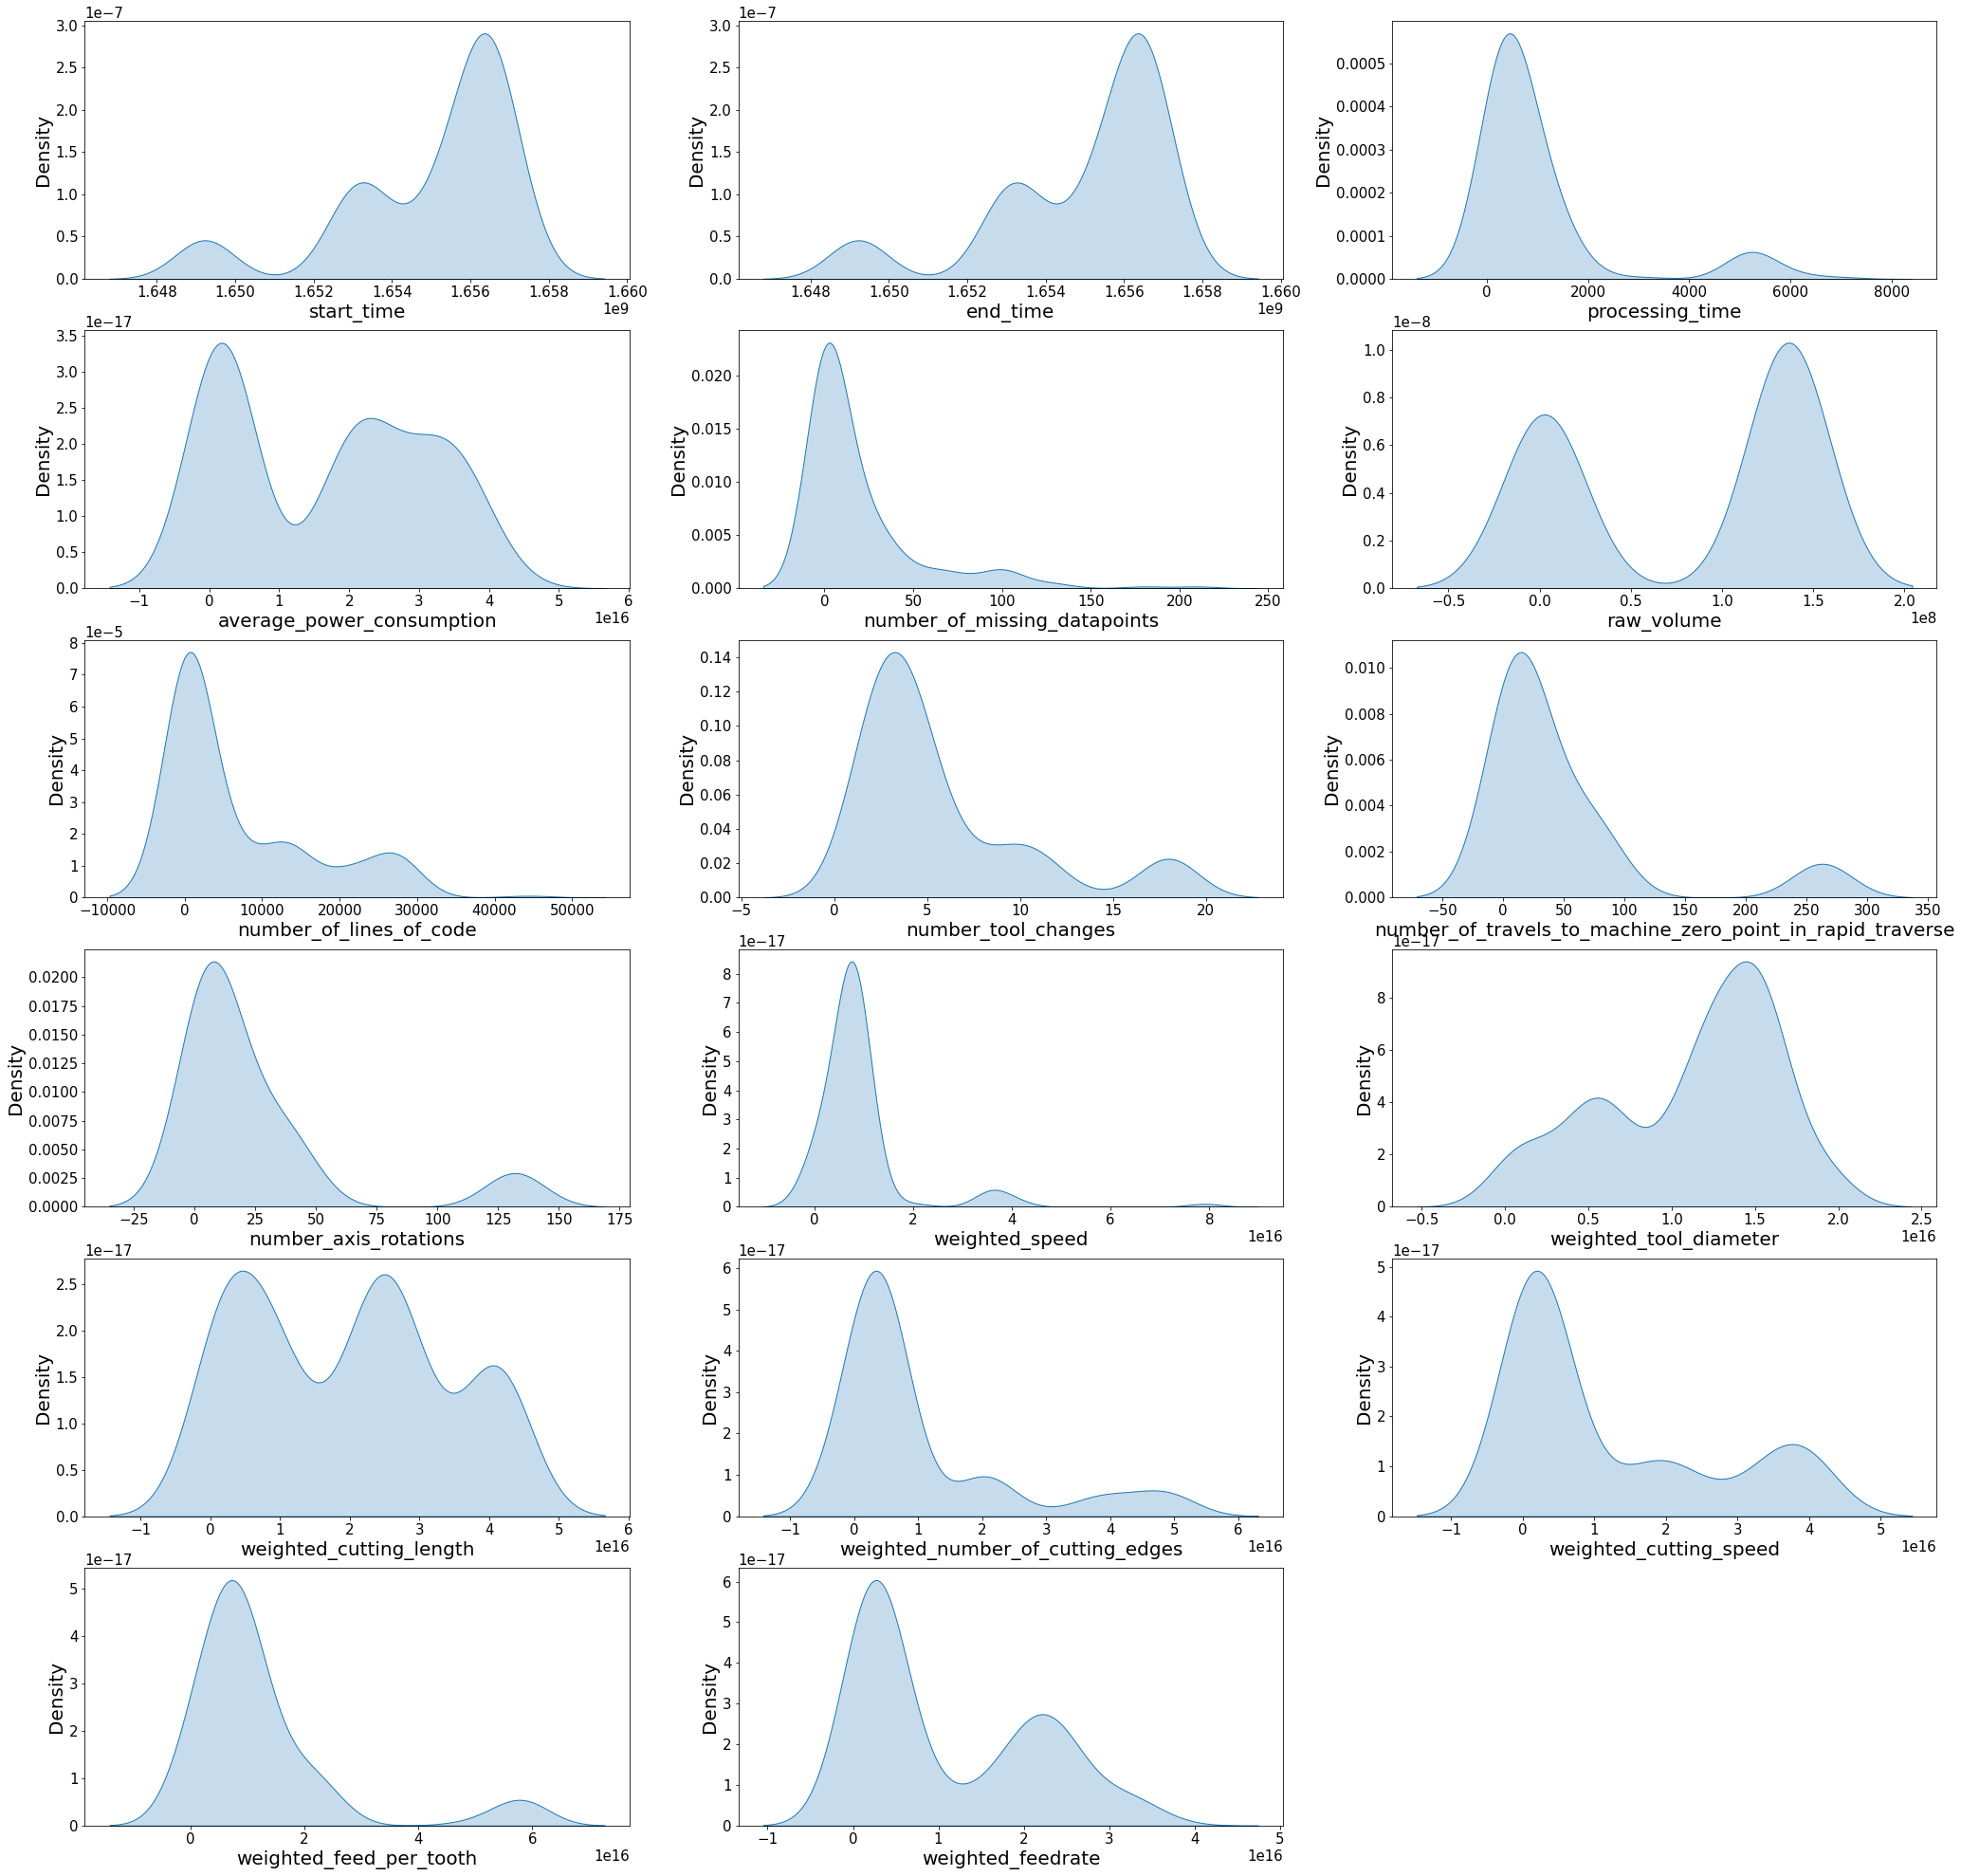

In [52]:

num_rows, num_cols = 6, 3

# plot histogram
plot_histogram(df,  num_rows, num_cols)


#### Outlier detection using box plot

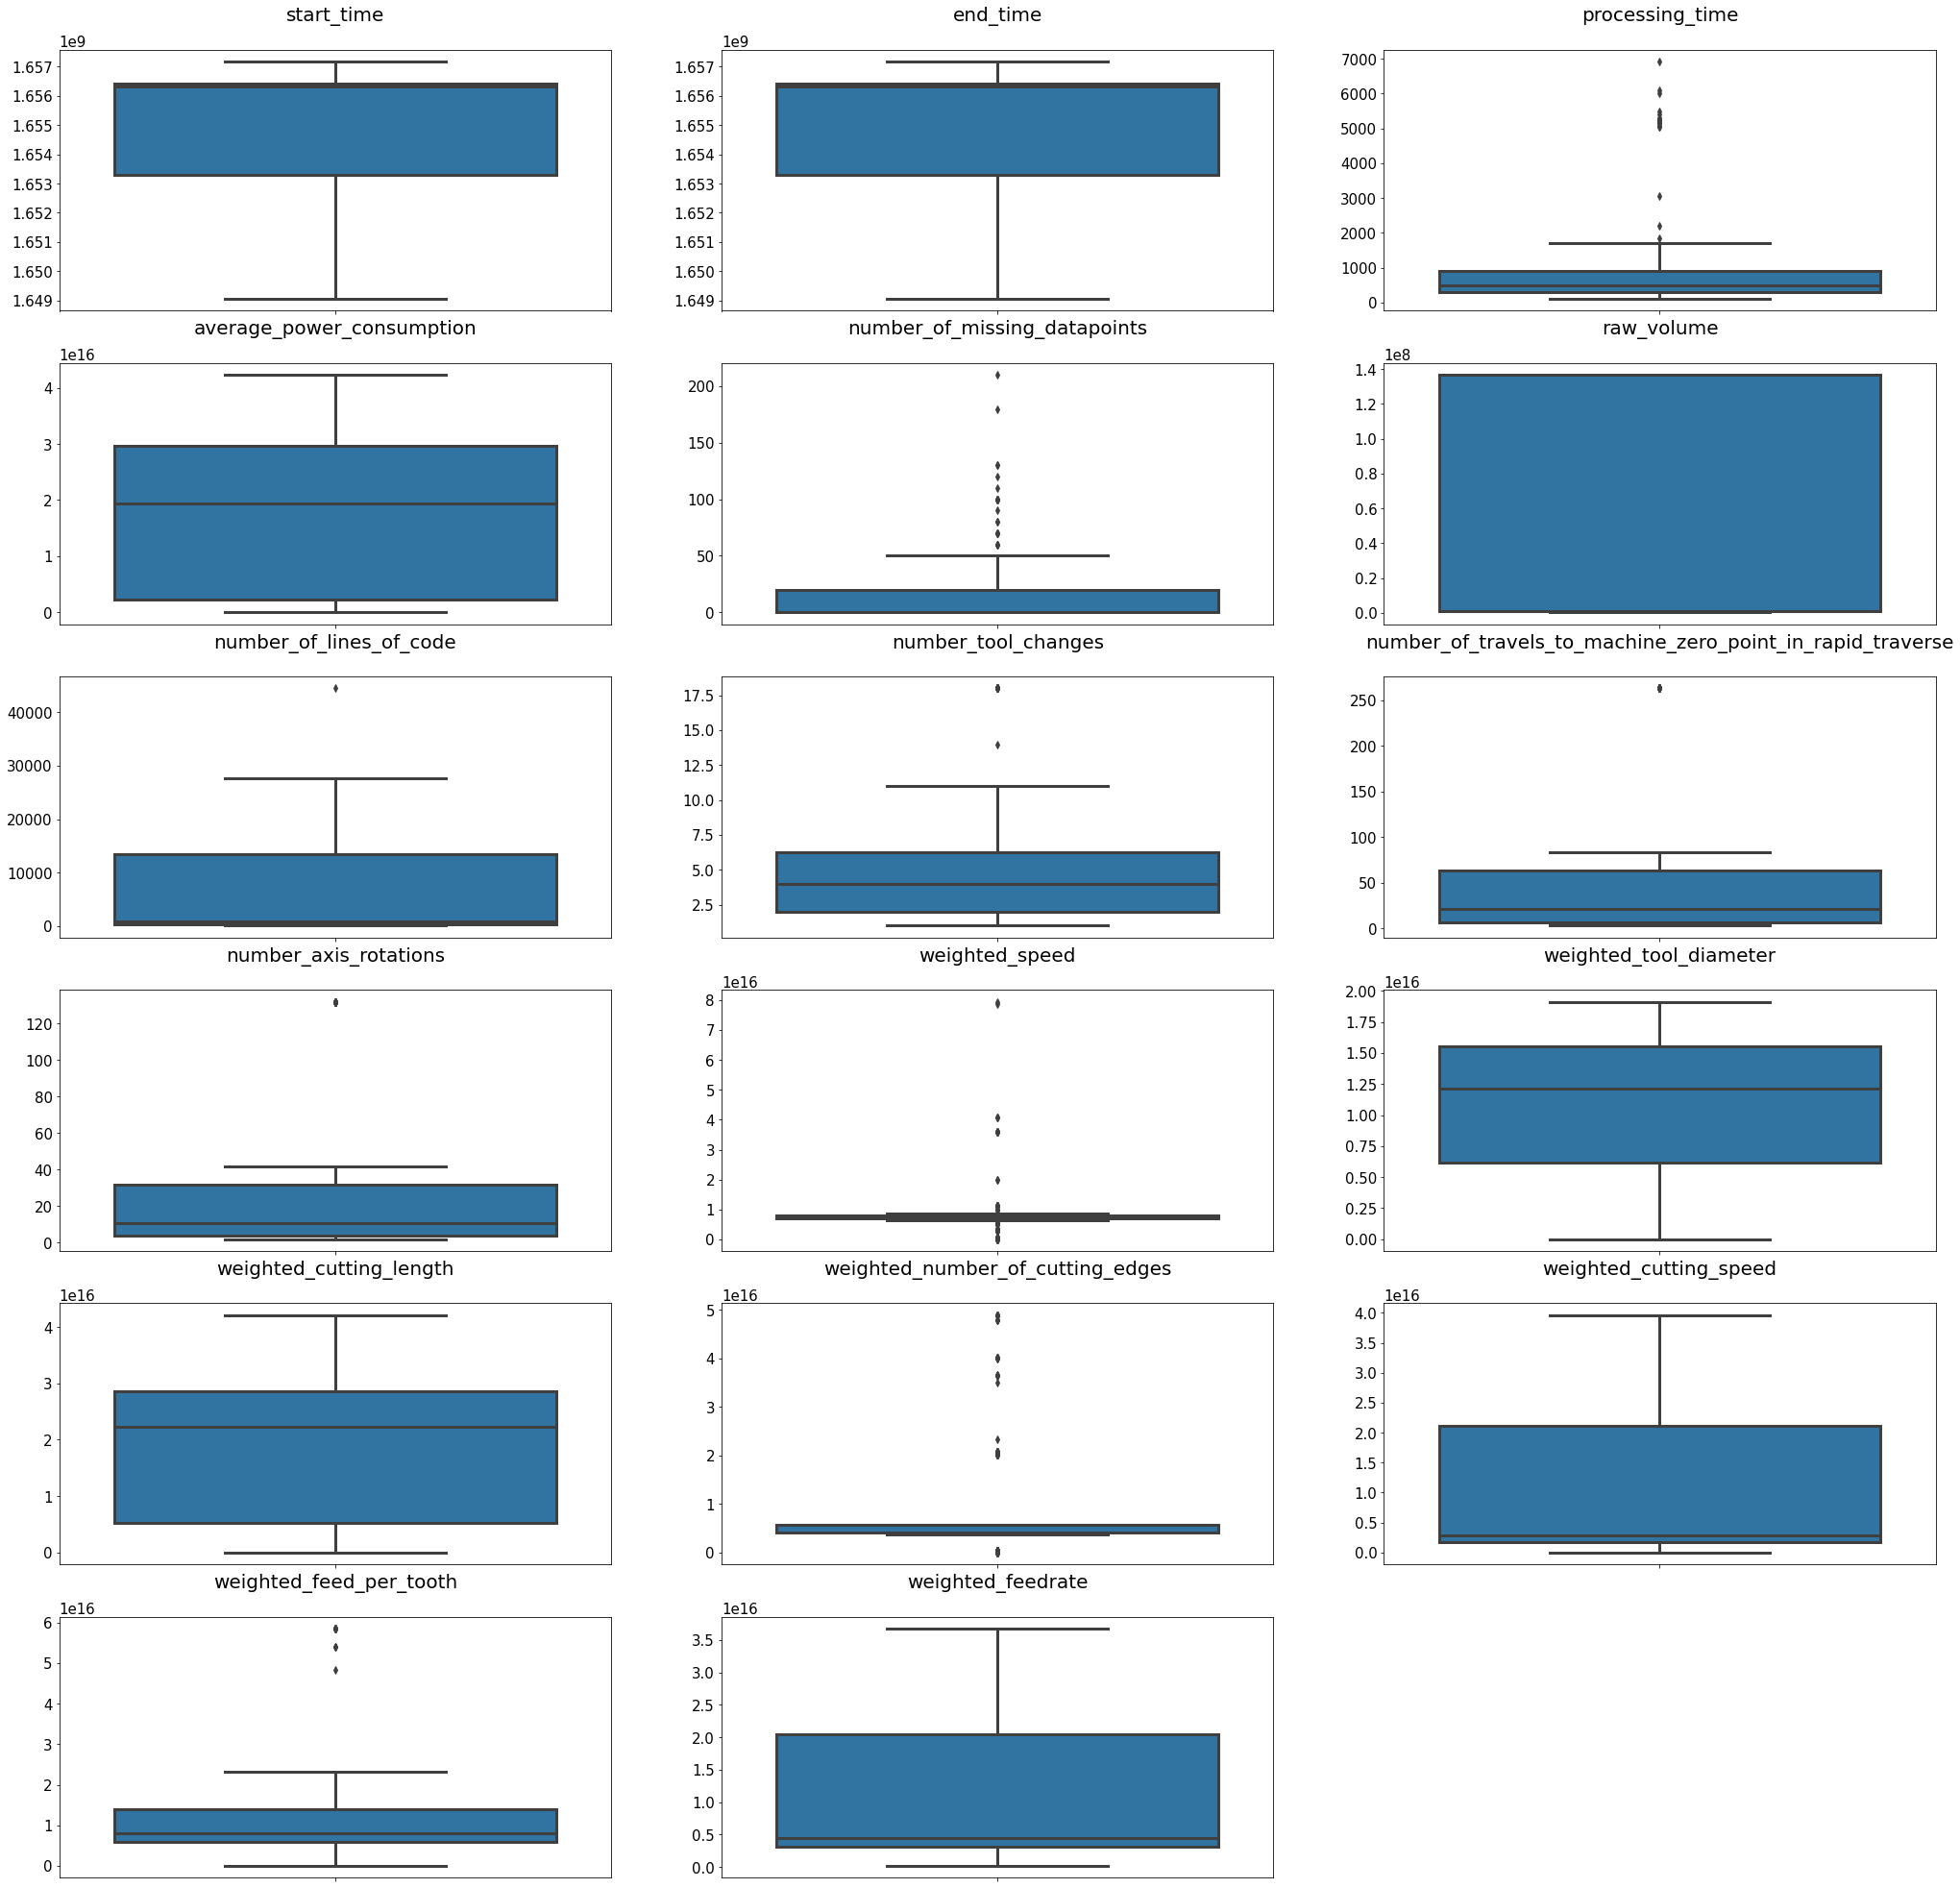

In [53]:
plot_boxplot(df, num_rows, num_cols)

From the above distribution plots, we can see that most of the features are not normally distributed.

From the above boxplots, we see that we have very few cases of outliers in the data. <br><br>

#### Correlation among predictor and traget Feature 

#### Pearson Correlation

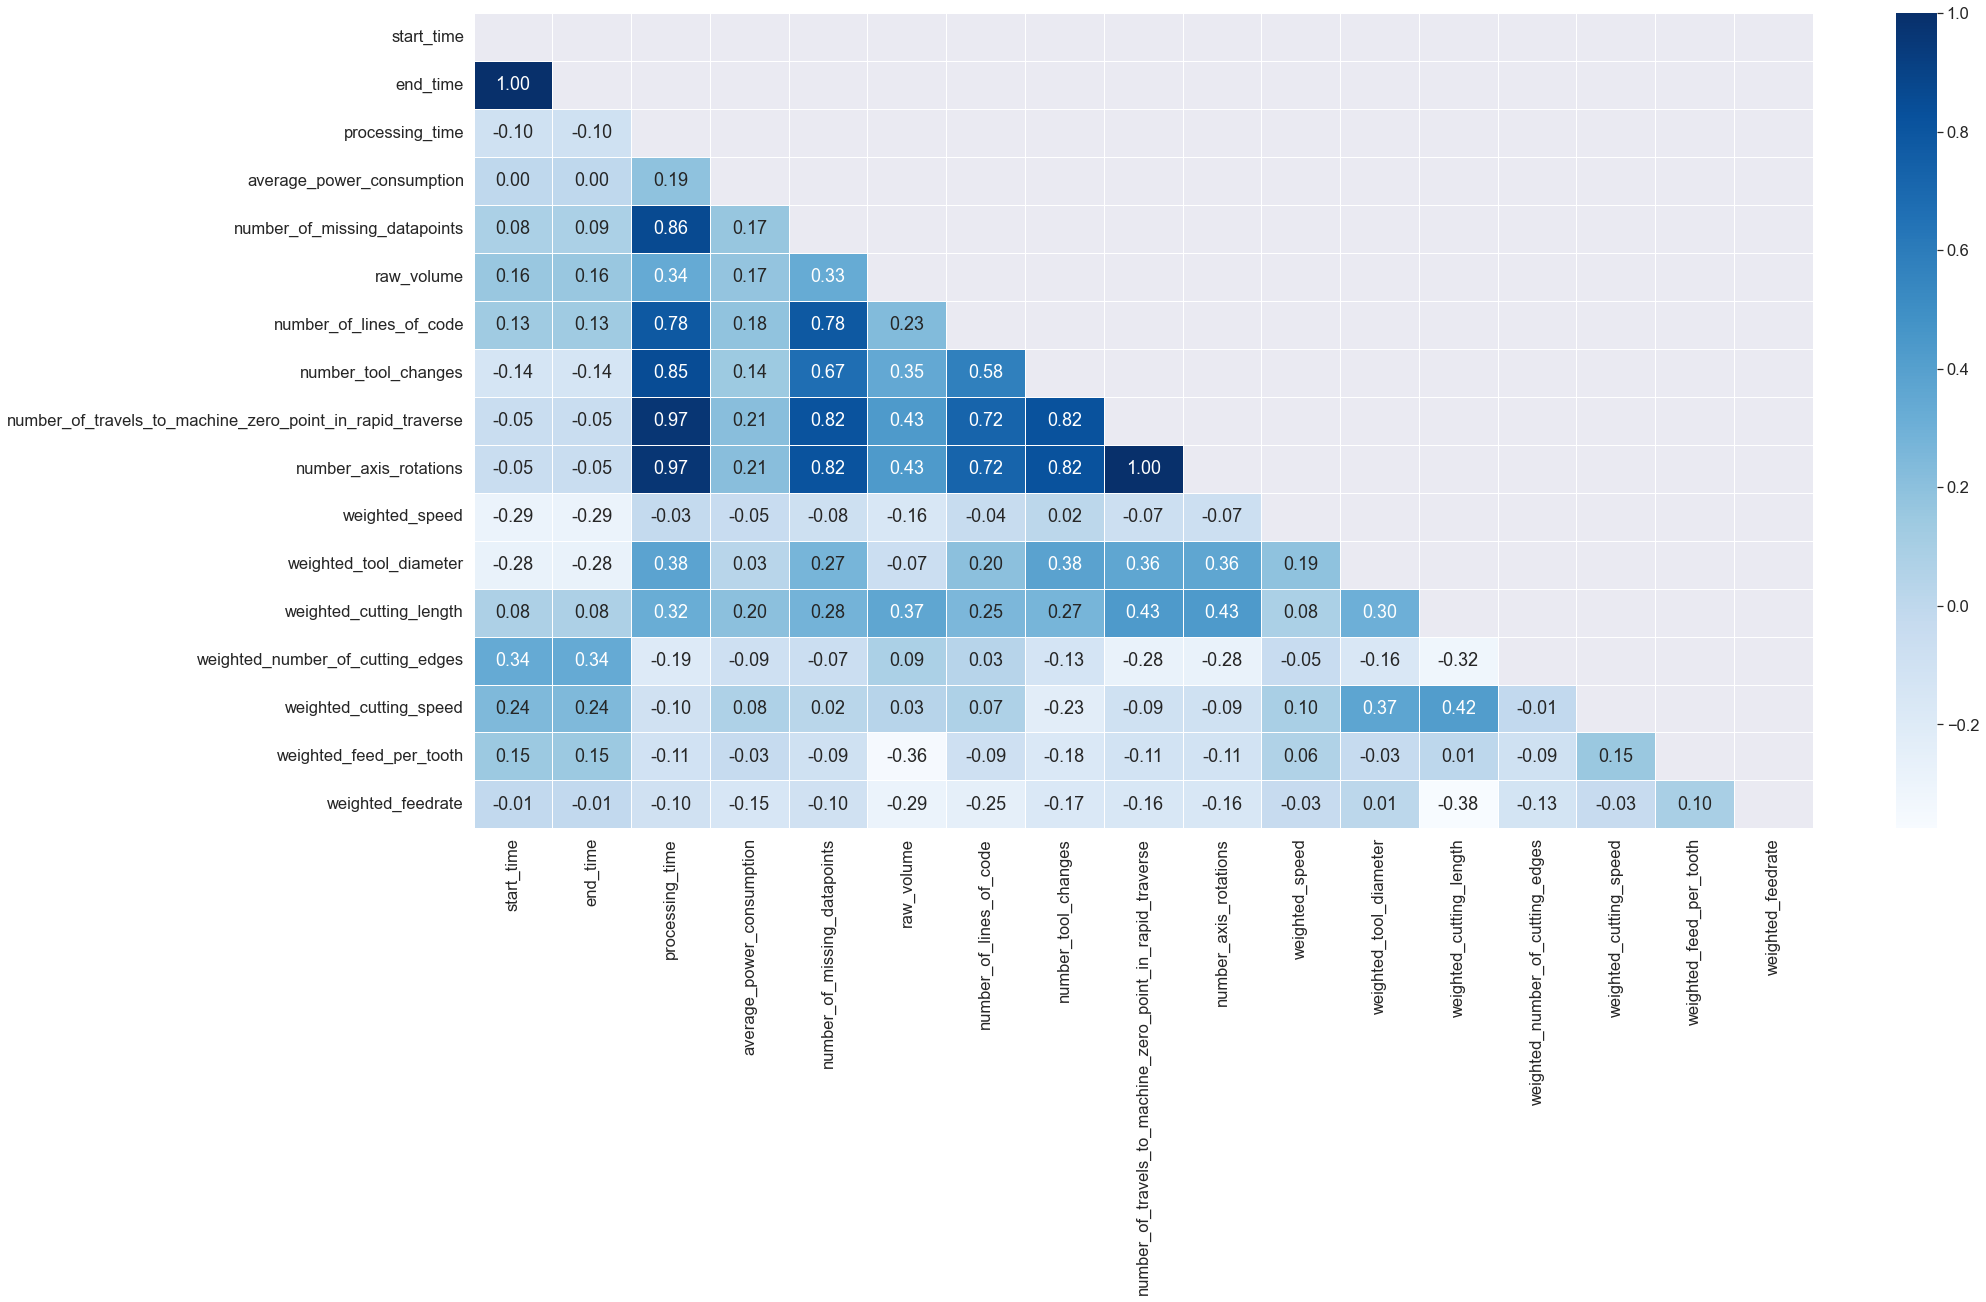

Pearson Correlation: Most Correlated Feature with processing_time:


processing_time                                              1.000000
number_of_travels_to_machine_zero_point_in_rapid_traverse    0.966316
number_axis_rotations                                        0.966316
number_of_missing_datapoints                                 0.863548
number_tool_changes                                          0.853962
number_of_lines_of_code                                      0.784716
weighted_tool_diameter                                       0.381967
raw_volume                                                   0.336831
weighted_cutting_length                                      0.318705
average_power_consumption                                    0.188783
weighted_speed                                              -0.025400
end_time                                                    -0.095305
start_time                                                  -0.095957
weighted_cutting_speed                                      -0.098022
weighted_feedrate   

Pearson Correlation: Most Correlated Feature with average_power_consumption:


average_power_consumption                                    1.000000
number_of_travels_to_machine_zero_point_in_rapid_traverse    0.212727
number_axis_rotations                                        0.212727
weighted_cutting_length                                      0.202067
processing_time                                              0.188783
number_of_lines_of_code                                      0.184588
raw_volume                                                   0.174706
number_of_missing_datapoints                                 0.167220
number_tool_changes                                          0.144057
weighted_cutting_speed                                       0.075718
weighted_tool_diameter                                       0.032825
end_time                                                     0.000278
start_time                                                   0.000154
weighted_feed_per_tooth                                     -0.028836
weighted_speed      

{'processing_time': {'processing_time': 1.0, 'number_of_travels_to_machine_zero_point_in_rapid_traverse': 0.9663155799051536, 'number_axis_rotations': 0.9663155799051536, 'number_of_missing_datapoints': 0.8635476427765126, 'number_tool_changes': 0.8539617274136422, 'number_of_lines_of_code': 0.784716314047019, 'weighted_tool_diameter': 0.3819666230082605, 'raw_volume': 0.33683084521286827, 'weighted_cutting_length': 0.3187048983886916, 'average_power_consumption': 0.18878316221187358, 'weighted_speed': -0.02540047045699207, 'end_time': -0.09530514540016667, 'start_time': -0.09595720578422794, 'weighted_cutting_speed': -0.09802179012444906, 'weighted_feedrate': -0.10024342131850598, 'weighted_feed_per_tooth': -0.10906721054895897, 'weighted_number_of_cutting_edges': -0.19332367809277143}, 'average_power_consumption': {'average_power_consumption': 1.0, 'number_of_travels_to_machine_zero_point_in_rapid_traverse': 0.21272705262456887, 'number_axis_rotations': 0.21272705262456887, 'weighted

In [85]:
pear_cor_vals = {}
pearson_corr = df.corr(method='pearson')
mask = np.triu(kendall_corr) # mask to show lower triangular matrix

plt.figure(figsize=(30,15))
sns.heatmap(pearson_corr,  mask=mask, annot=True, cmap="Blues",
            fmt='.2f', linewidth=.5)

plt.show()

print("Pearson Correlation: Most Correlated Feature with processing_time:")
prc_df_most_corrs = pearson_corr['processing_time'].sort_values(ascending=False)
pear_cor_vals['processing_time'] = dict(prc_df_most_corrs)
display(prc_df_most_corrs)

print("Pearson Correlation: Most Correlated Feature with average_power_consumption:")
prc_df_most_corrs = pearson_corr['average_power_consumption'].sort_values(ascending=False)
display(prc_df_most_corrs)
pear_cor_vals['average_power_consumption'] = dict(prc_df_most_corrs)

- From Pearson correlation the following can be deduce for proceessing_time:
    1. processing_time is correlated with the following features:
        - number_of_travels_to_machine_zero_point_in_rapid_traverse (0.966316)
        - number_axis_rotations (0.966316)
        - number_of_missing_datapoints (0.863548)
        - number_tool_changes (0.853962)
        - number_of_lines_of_code (0.853962)
        - weighted_tool_diameter (0.784716)
        - weighted_cutting_length (0.381967)
        - raw_volume (0.336831)
        - weighted_cutting_length (0.318705)
    2. average_power_consumption is correlated with the following features:
        - number_of_travels_to_machine_zero_point_in_rapid_traverse    (0.212727)
        - number_axis_rotations                                        (0.212727)
        - weighted_cutting_length                                      (0.202067)
        - number_of_lines_of_code                                      (0.184588)
        - raw_volume                                                   (0.174706)
        - number_of_missing_datapoints                                 (0.167220)
        - number_tool_changes                                          (0.144057)


**Spearman correlation**

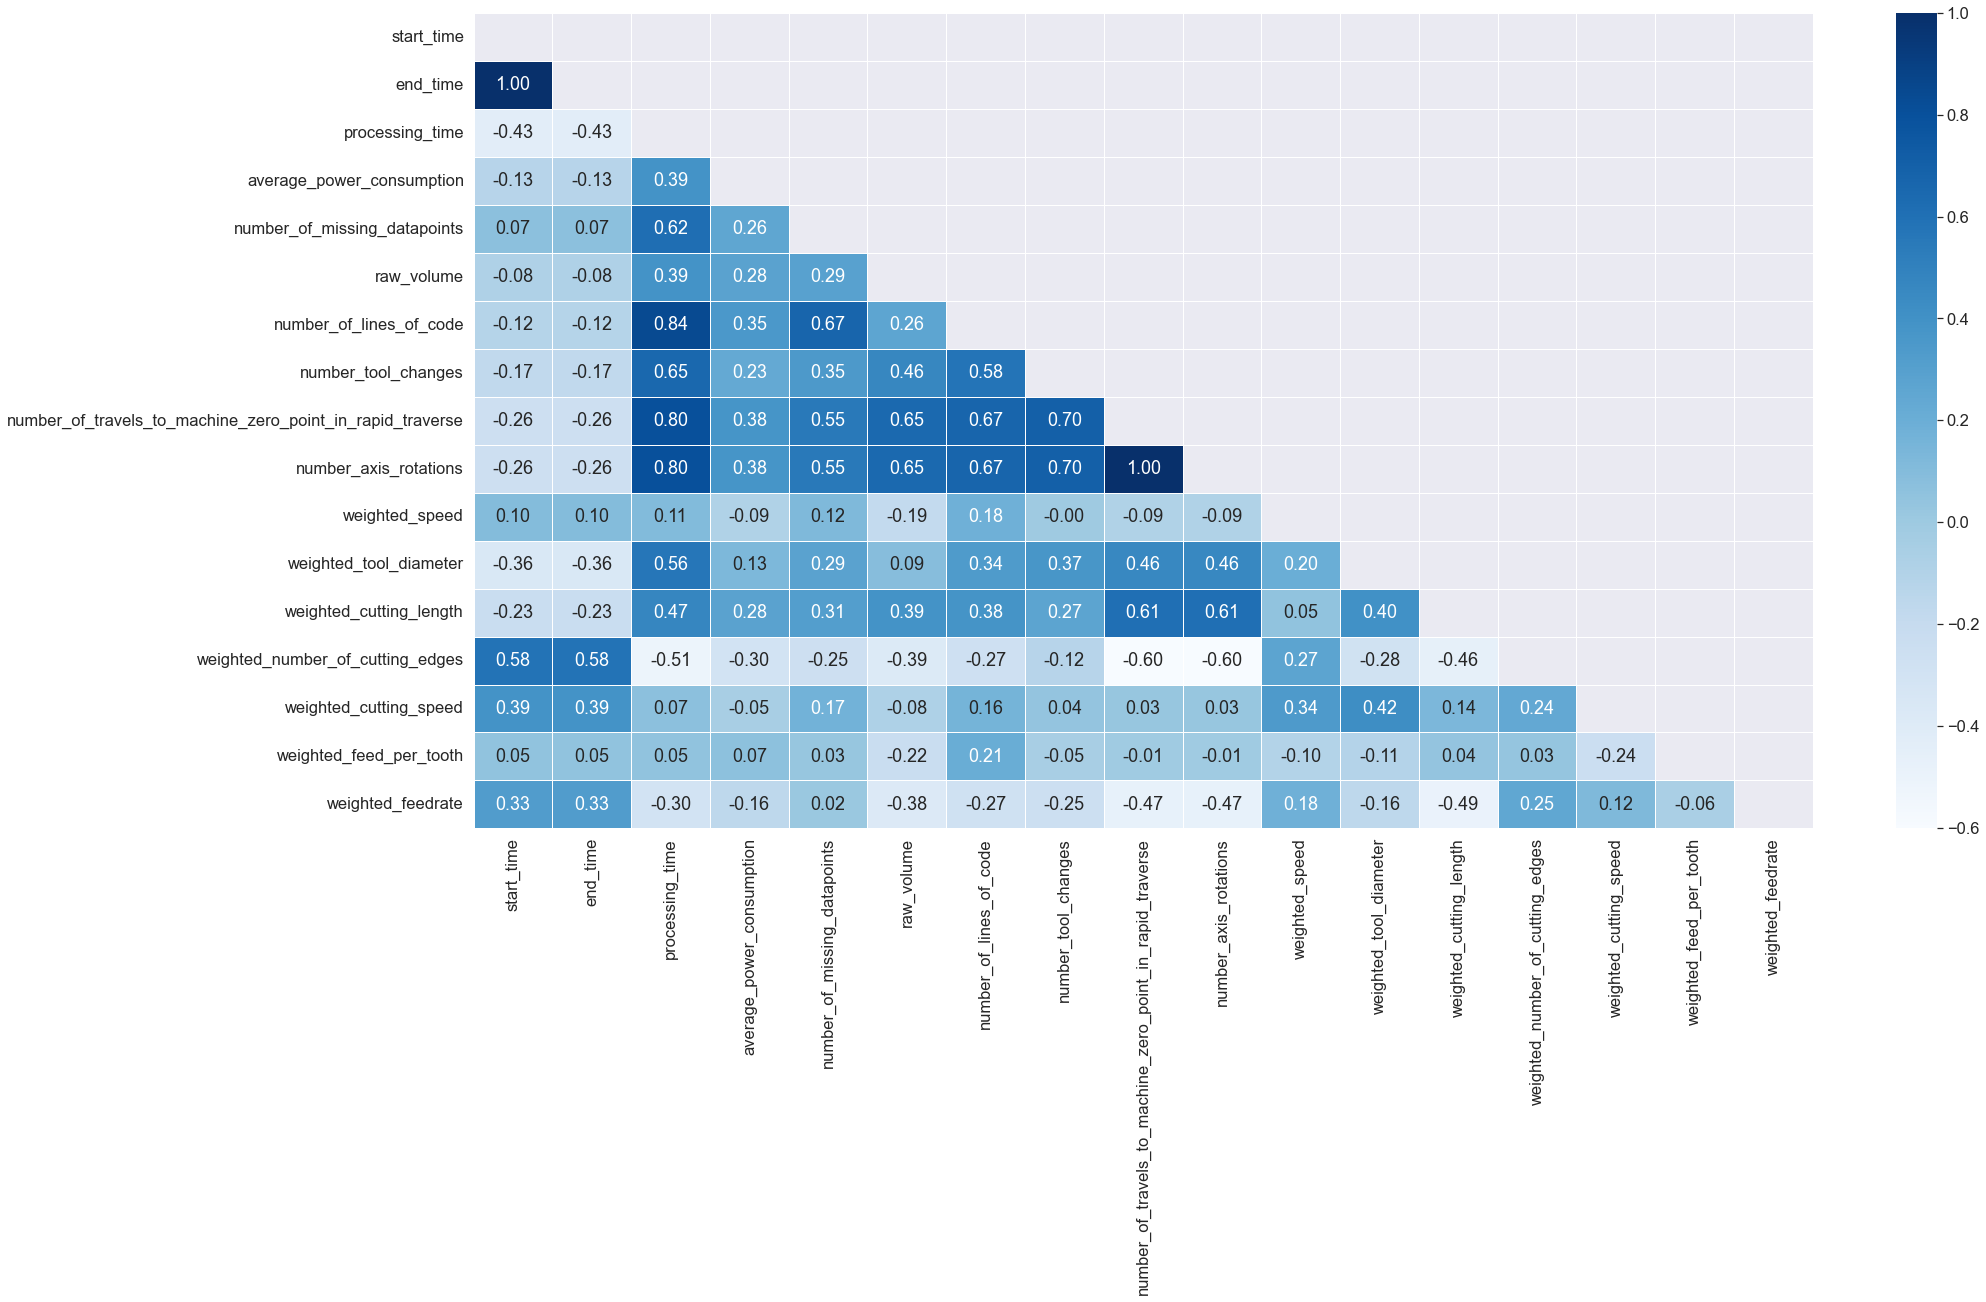

Spearman correlation: Most Correlated Feature with processing_time:


processing_time                                              1.000000
number_of_lines_of_code                                      0.841590
number_of_travels_to_machine_zero_point_in_rapid_traverse    0.802062
number_axis_rotations                                        0.802062
number_tool_changes                                          0.652762
number_of_missing_datapoints                                 0.616476
weighted_tool_diameter                                       0.562307
weighted_cutting_length                                      0.473984
average_power_consumption                                    0.392470
raw_volume                                                   0.391840
weighted_speed                                               0.107656
weighted_cutting_speed                                       0.072152
weighted_feed_per_tooth                                      0.049674
weighted_feedrate                                           -0.300365
end_time            

Spearman correlation: Most Correlated Feature with average_power_consumption:


average_power_consumption                                    1.000000
processing_time                                              0.392470
number_of_travels_to_machine_zero_point_in_rapid_traverse    0.379675
number_axis_rotations                                        0.379675
number_of_lines_of_code                                      0.352183
raw_volume                                                   0.284420
weighted_cutting_length                                      0.282016
number_of_missing_datapoints                                 0.257037
number_tool_changes                                          0.231078
weighted_tool_diameter                                       0.126745
weighted_feed_per_tooth                                      0.066230
weighted_cutting_speed                                      -0.051061
weighted_speed                                              -0.089198
start_time                                                  -0.125936
end_time            

In [86]:
spear_cor_vals = {}
spearman_corr = df.corr(method='spearman')
mask = np.triu(spearman_corr)

# plot
plt.figure(figsize=(30,15))
sns.heatmap(spearman_corr,  mask=mask, annot=True, cmap="Blues", fmt='.2f', linewidth=.5)

plt.show()

print("Spearman correlation: Most Correlated Feature with processing_time:")
spm_df_most_corrs = spearman_corr['processing_time'].sort_values(ascending=False)
display(spm_df_most_corrs)
spear_cor_vals['processing_time'] = dict(spm_df_most_corrs)

print("Spearman correlation: Most Correlated Feature with average_power_consumption:")
spm_df_most_corrs = spearman_corr['average_power_consumption'].sort_values(ascending=False)
display(spm_df_most_corrs)
spear_cor_vals['average_power_consumption'] = dict(spm_df_most_corrs)

- From Spearman correlation the following can be deduce for proceessing_time:
    1. processing_time is positively correlated with the following features:
        - number_of_lines_of_code                                      (0.841590)
        - number_of_travels_to_machine_zero_point_in_rapid_traverse    (0.802062)
        - number_axis_rotations                                        (0.802062)
        - number_tool_changes                                          (0.652762)
        - number_of_missing_datapoints                                 (0.616476)
        - weighted_tool_diameter                                       (0.562307)
        - weighted_cutting_length                                      (0.473984)
        - average_power_consumption                                    (0.392470)
        - raw_volume                                                   (0.391840)
    2. average_power_consumption is correlated with the following features:
        - number_of_travels_to_machine_zero_point_in_rapid_traverse    (0.379675)
        - number_axis_rotations                                        (0.379675)
        - weighted_cutting_length                                      (0.379675)
        - number_of_lines_of_code                                      (0.352183)
        - raw_volume                                                   (0.284420)
        - number_of_missing_datapoints                                 (0.282016)
        - number_tool_changes (0.231078)
        - weighted_tool_diameter                                       (0.126745)
        - weighted_number_of_cutting_edges                             (-0.301392)


#### Kendall correlation

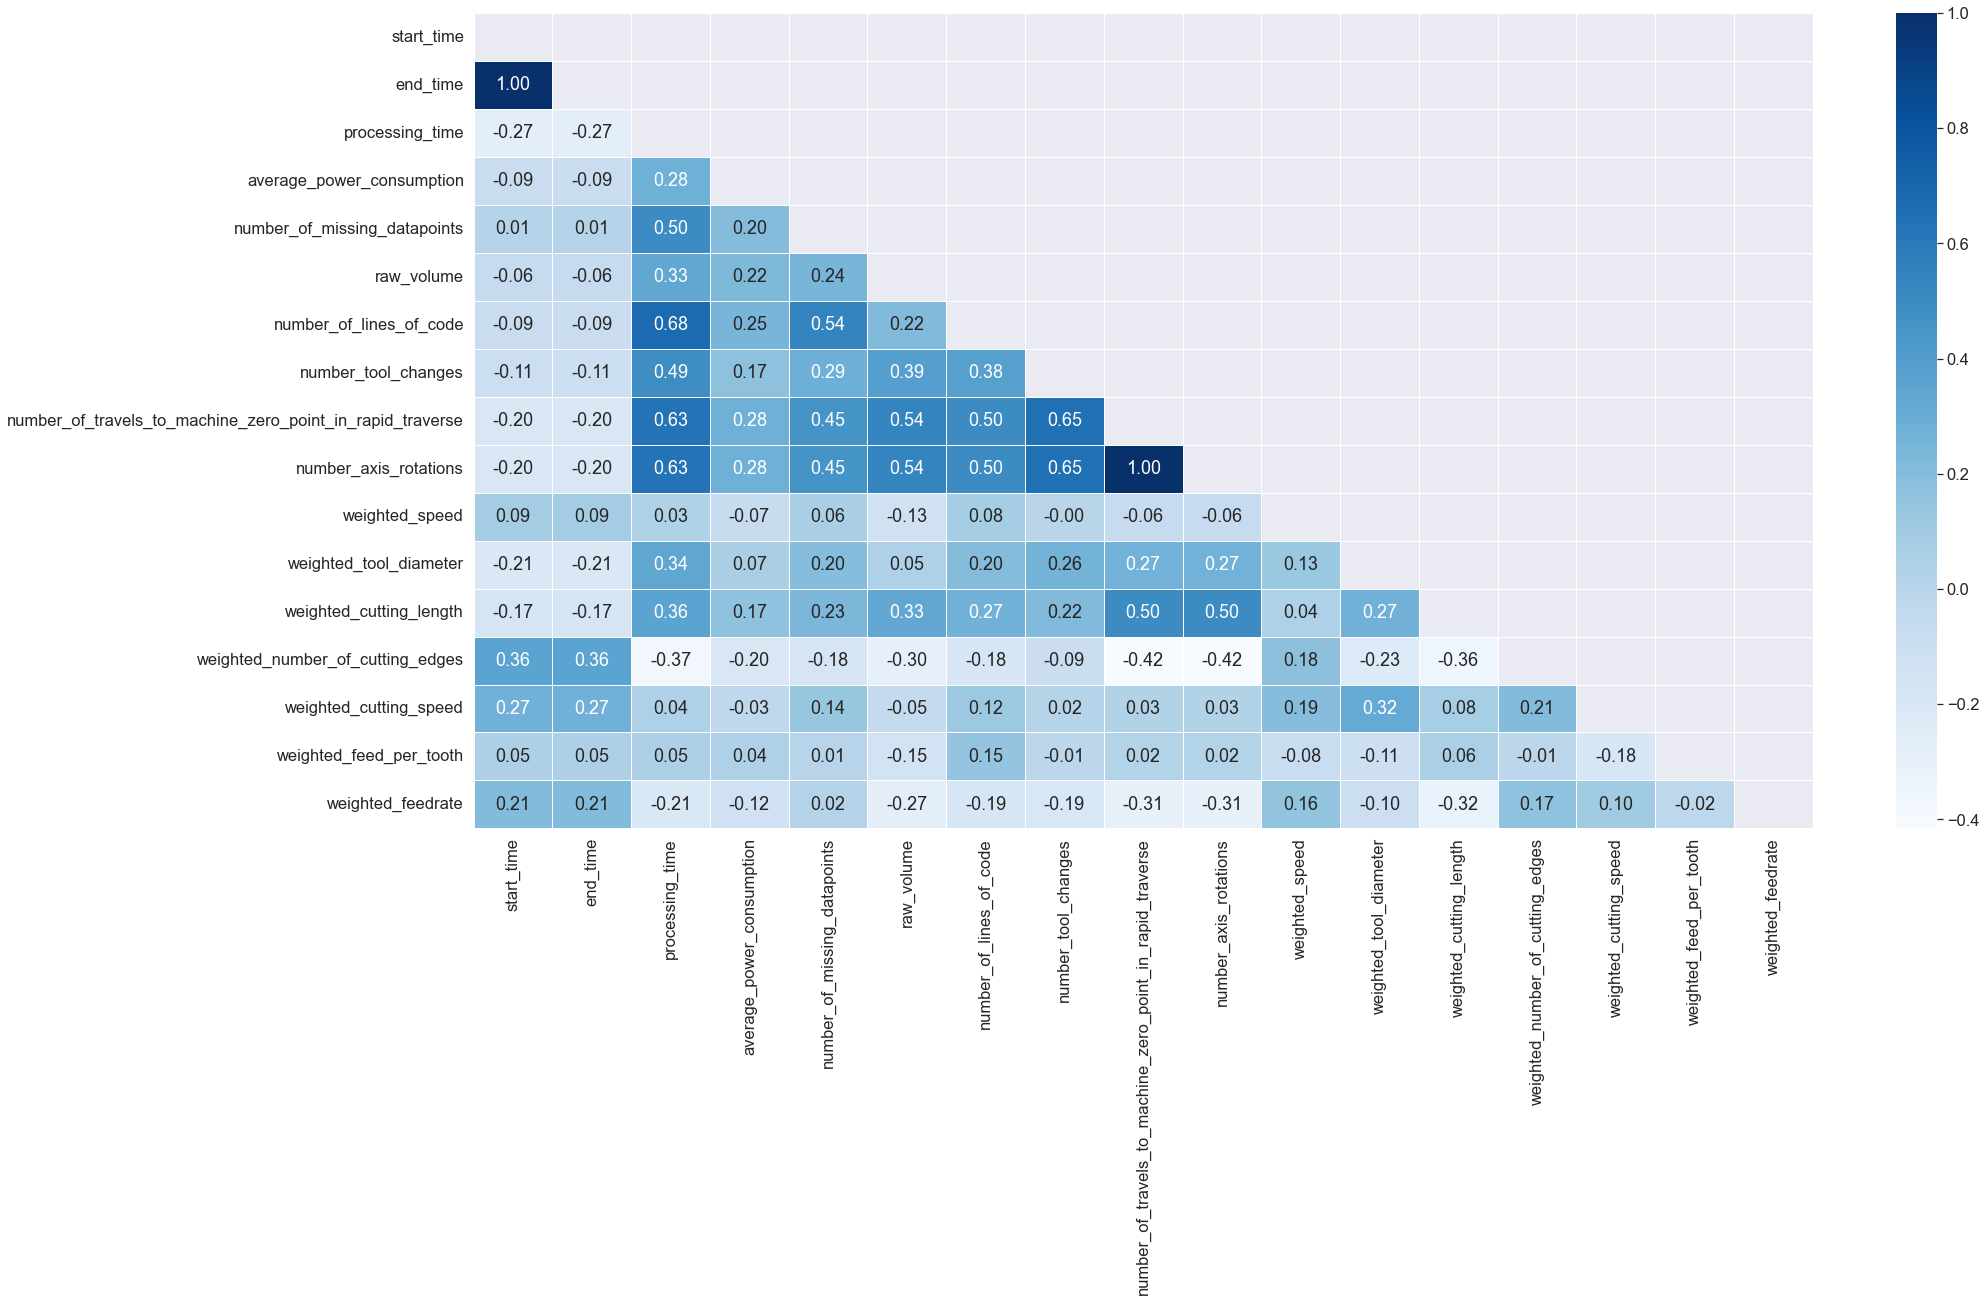

Kendall correlation: Most Correlated Feature with processing_time:


processing_time                                              1.000000
number_of_lines_of_code                                      0.677163
number_of_travels_to_machine_zero_point_in_rapid_traverse    0.632523
number_axis_rotations                                        0.632523
number_of_missing_datapoints                                 0.498878
number_tool_changes                                          0.490652
weighted_cutting_length                                      0.363393
weighted_tool_diameter                                       0.343965
raw_volume                                                   0.333568
average_power_consumption                                    0.276470
weighted_feed_per_tooth                                      0.053285
weighted_cutting_speed                                       0.044785
weighted_speed                                               0.033963
weighted_feedrate                                           -0.205283
end_time            

Kendall correlation: Most Correlated Feature with average_power_consumption:


average_power_consumption                                    1.000000
number_of_travels_to_machine_zero_point_in_rapid_traverse    0.279073
number_axis_rotations                                        0.279073
processing_time                                              0.276470
number_of_lines_of_code                                      0.245089
raw_volume                                                   0.221317
number_of_missing_datapoints                                 0.201474
number_tool_changes                                          0.171256
weighted_cutting_length                                      0.167915
weighted_tool_diameter                                       0.065219
weighted_feed_per_tooth                                      0.041657
weighted_cutting_speed                                      -0.028880
weighted_speed                                              -0.074029
start_time                                                  -0.086011
end_time            

In [87]:
ken_cor_vals = {}
kendall_corr = df.corr(method='kendall')
mask = np.triu(kendall_corr) # mask to show lower triangular matrix

plt.figure(figsize=(30,15))
sns.heatmap(kendall_corr,  mask=mask, annot=True, cmap="Blues",
            fmt='.2f', linewidth=.5)

plt.show()

print("Kendall correlation: Most Correlated Feature with processing_time:")
ken_df_most_corrs = kendall_corr['processing_time'].sort_values(ascending=False)
display(ken_df_most_corrs)
ken_cor_vals['processing_time'] = ken_df_most_corrs

print("Kendall correlation: Most Correlated Feature with average_power_consumption:")
ken_df_most_corrs = kendall_corr['average_power_consumption'].sort_values(ascending=False)
display(ken_df_most_corrs)
ken_cor_vals['processing_time'] = ken_df_most_corrs

### Feature Extraction 

- Removal start_time and end_time becacue the difference of it gives the target variable processing_time
- Removal of the number of axis of rotation: This feature is strongly correlated to the number_of_travels_to_machine_zero_point_in_rapid_traverse

In [359]:
df_final = df.drop(columns=['start_time', 'end_time', 'number_axis_rotations', 'number_of_missing_datapoints',
                           'weighted_feed_per_tooth', 'weighted_cutting_speed', 'weighted_speed'])
Xvar_df = df_final.drop(columns=['processing_time', 'average_power_consumption'])
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 10 columns):
 #   Column                                                     Non-Null Count  Dtype
---  ------                                                     --------------  -----
 0   processing_time                                            220 non-null    int64
 1   average_power_consumption                                  220 non-null    int64
 2   raw_volume                                                 220 non-null    int64
 3   number_of_lines_of_code                                    220 non-null    int64
 4   number_tool_changes                                        220 non-null    int64
 5   number_of_travels_to_machine_zero_point_in_rapid_traverse  220 non-null    int64
 6   weighted_tool_diameter                                     220 non-null    int64
 7   weighted_cutting_length                                    220 non-null    int64
 8   weighted_number_of_cutting_edg

In [353]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 14 columns):
 #   Column                                                     Non-Null Count  Dtype
---  ------                                                     --------------  -----
 0   processing_time                                            220 non-null    int64
 1   average_power_consumption                                  220 non-null    int64
 2   number_of_missing_datapoints                               220 non-null    int64
 3   raw_volume                                                 220 non-null    int64
 4   number_of_lines_of_code                                    220 non-null    int64
 5   number_tool_changes                                        220 non-null    int64
 6   number_of_travels_to_machine_zero_point_in_rapid_traverse  220 non-null    int64
 7   weighted_speed                                             220 non-null    int64
 8   weighted_tool_diameter        

### Feature Scaling of the data

We have to scale or standardise our dataset before carrying out any type of regression, because
- the scale of the values across the different variables are very different.

We will scale the data using `MinMaxScaler()`, and standardise the data using `StandardScaler()` from `sklearn` Python package.

#### Scaling using MinMaxScaler()

In [135]:
minmax_scaler = MinMaxScaler().fit(Xvar_df)
scaled_data = minmax_scaler.transform(Xvar_df)

# build a dataframe from the returned ndarray
reduced_df_scaled = pd.DataFrame(data=scaled_data, columns=Xvar_df.columns)
reduced_df_scaled.head()

,number_of_missing_datapoints,raw_volume,number_of_lines_of_code,number_tool_changes,number_of_travels_to_machine_zero_point_in_rapid_traverse,weighted_speed,weighted_tool_diameter,weighted_cutting_length,weighted_number_of_cutting_edges,weighted_cutting_speed,weighted_feed_per_tooth,weighted_feedrate
0,0.000000,1.000000,0.129027,0.235294,0.030769,1.000000,0.830542,0.103145,0.081934,0.100343,0.204553,1.000000
1,0.000000,1.000000,0.008477,0.176471,0.038462,0.990129,0.060034,0.665165,0.085982,0.718814,0.095862,0.000000
2,0.047619,0.001252,0.003337,0.058824,0.007692,0.090250,0.633650,0.125621,0.083925,0.039963,0.124112,0.553076
3,0.000000,0.001252,0.003337,0.058824,0.007692,0.090250,0.633650,0.125621,0.083925,0.039963,0.124112,0.553076
4,0.000000,0.001252,0.003337,0.058824,0.007692,0.090250,0.633650,0.125621,0.083925,0.039963,0.124112,0.553076


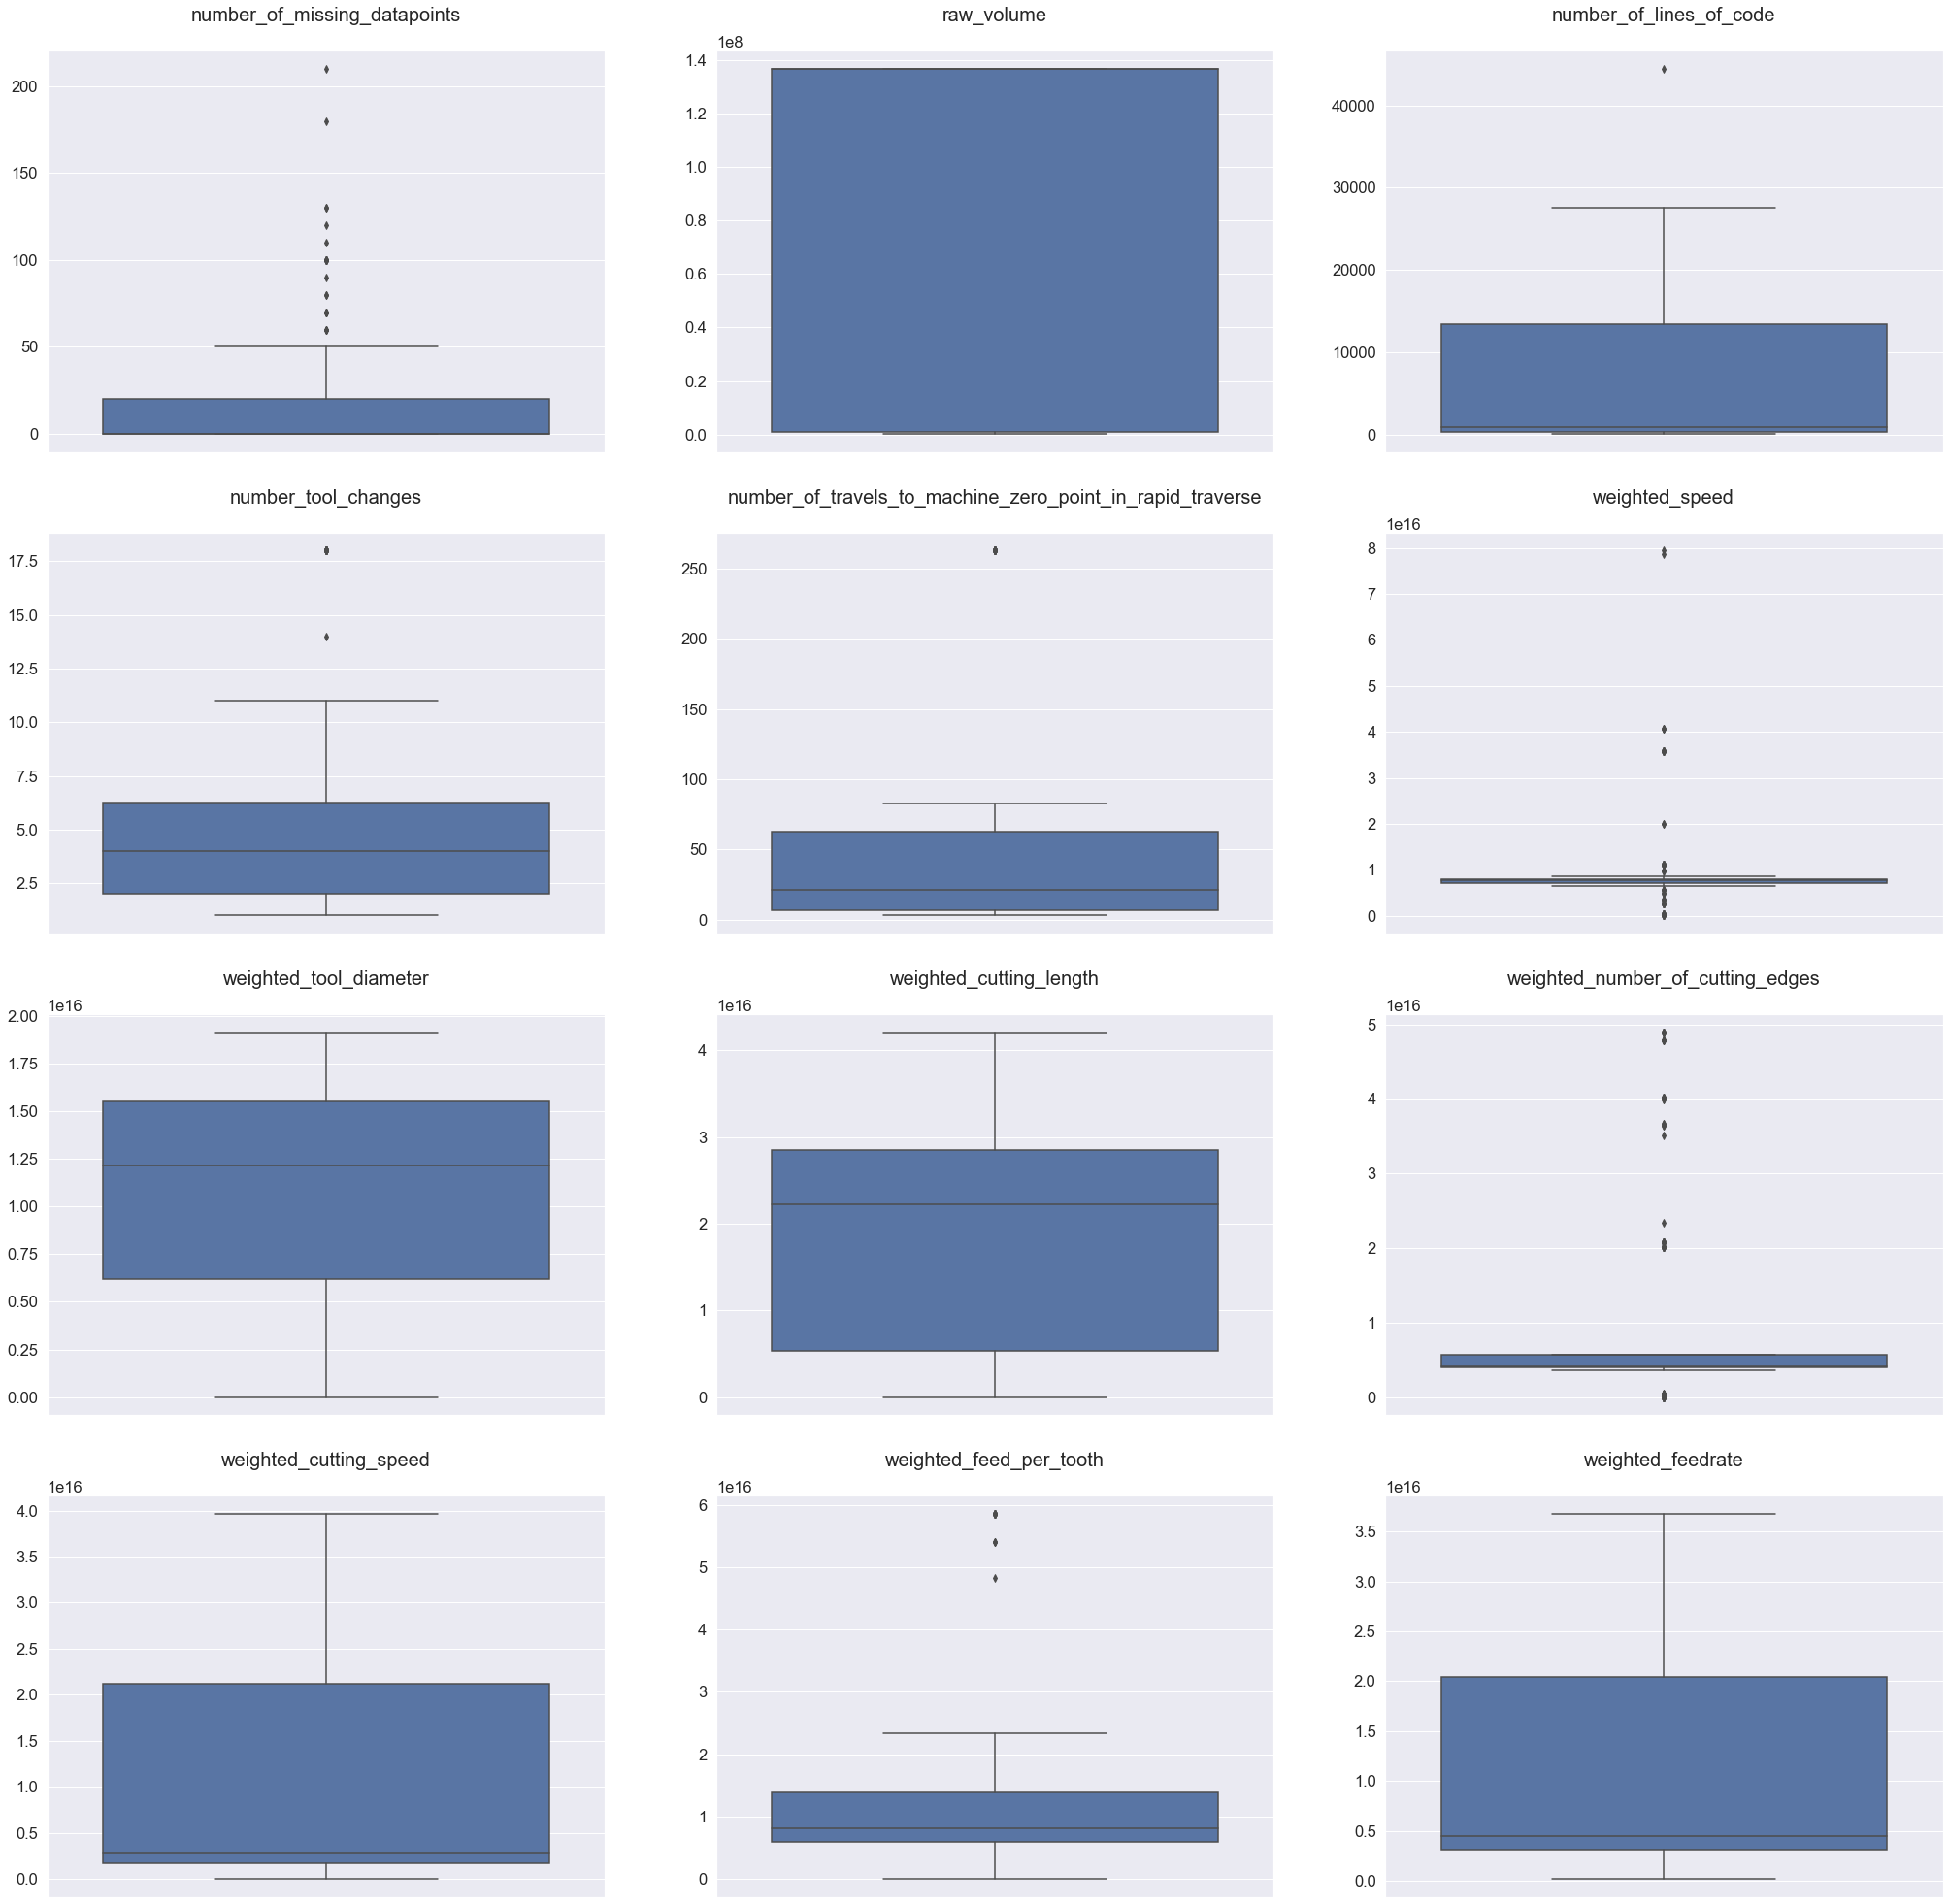

In [136]:
# boxplot of the scaled features
plot_boxplot(reduced_df_scaled, 4, 3)

### Standardisation using StandardScaler()

In [138]:
# initialise StandardScaler()
standard_scaler = StandardScaler().fit(Xvar_df)

# transform the dataset
standardised_data = standard_scaler.transform(Xvar_df)

# build a dataframe from the returned ndarray
reduced_df_standardised = pd.DataFrame(data=standardised_data, columns=Xvar_df.columns)
reduced_df_standardised.head()

,number_of_missing_datapoints,raw_volume,number_of_lines_of_code,number_tool_changes,number_of_travels_to_machine_zero_point_in_rapid_traverse,weighted_speed,weighted_tool_diameter,weighted_cutting_length,weighted_number_of_cutting_edges,weighted_cutting_speed,weighted_feed_per_tooth,weighted_feedrate
0,-0.572084,0.847130,-0.113451,-0.161747,-0.522065,6.842551,0.924299,-1.081772,-0.445425,-0.563947,-0.025677,2.465588
1,-0.572084,0.847130,-0.671869,-0.373558,-0.494429,6.766302,-1.924215,0.590767,-0.431190,1.135937,-0.484317,-1.032728
2,-0.275248,-1.215084,-0.695680,-0.797180,-0.604972,-0.184940,0.196406,-1.014883,-0.438423,-0.729902,-0.365110,0.902105
3,-0.572084,-1.215084,-0.695680,-0.797180,-0.604972,-0.184940,0.196406,-1.014883,-0.438423,-0.729902,-0.365110,0.902105
4,-0.572084,-1.215084,-0.695680,-0.797180,-0.604972,-0.184940,0.196406,-1.014883,-0.438423,-0.729902,-0.365110,0.902105


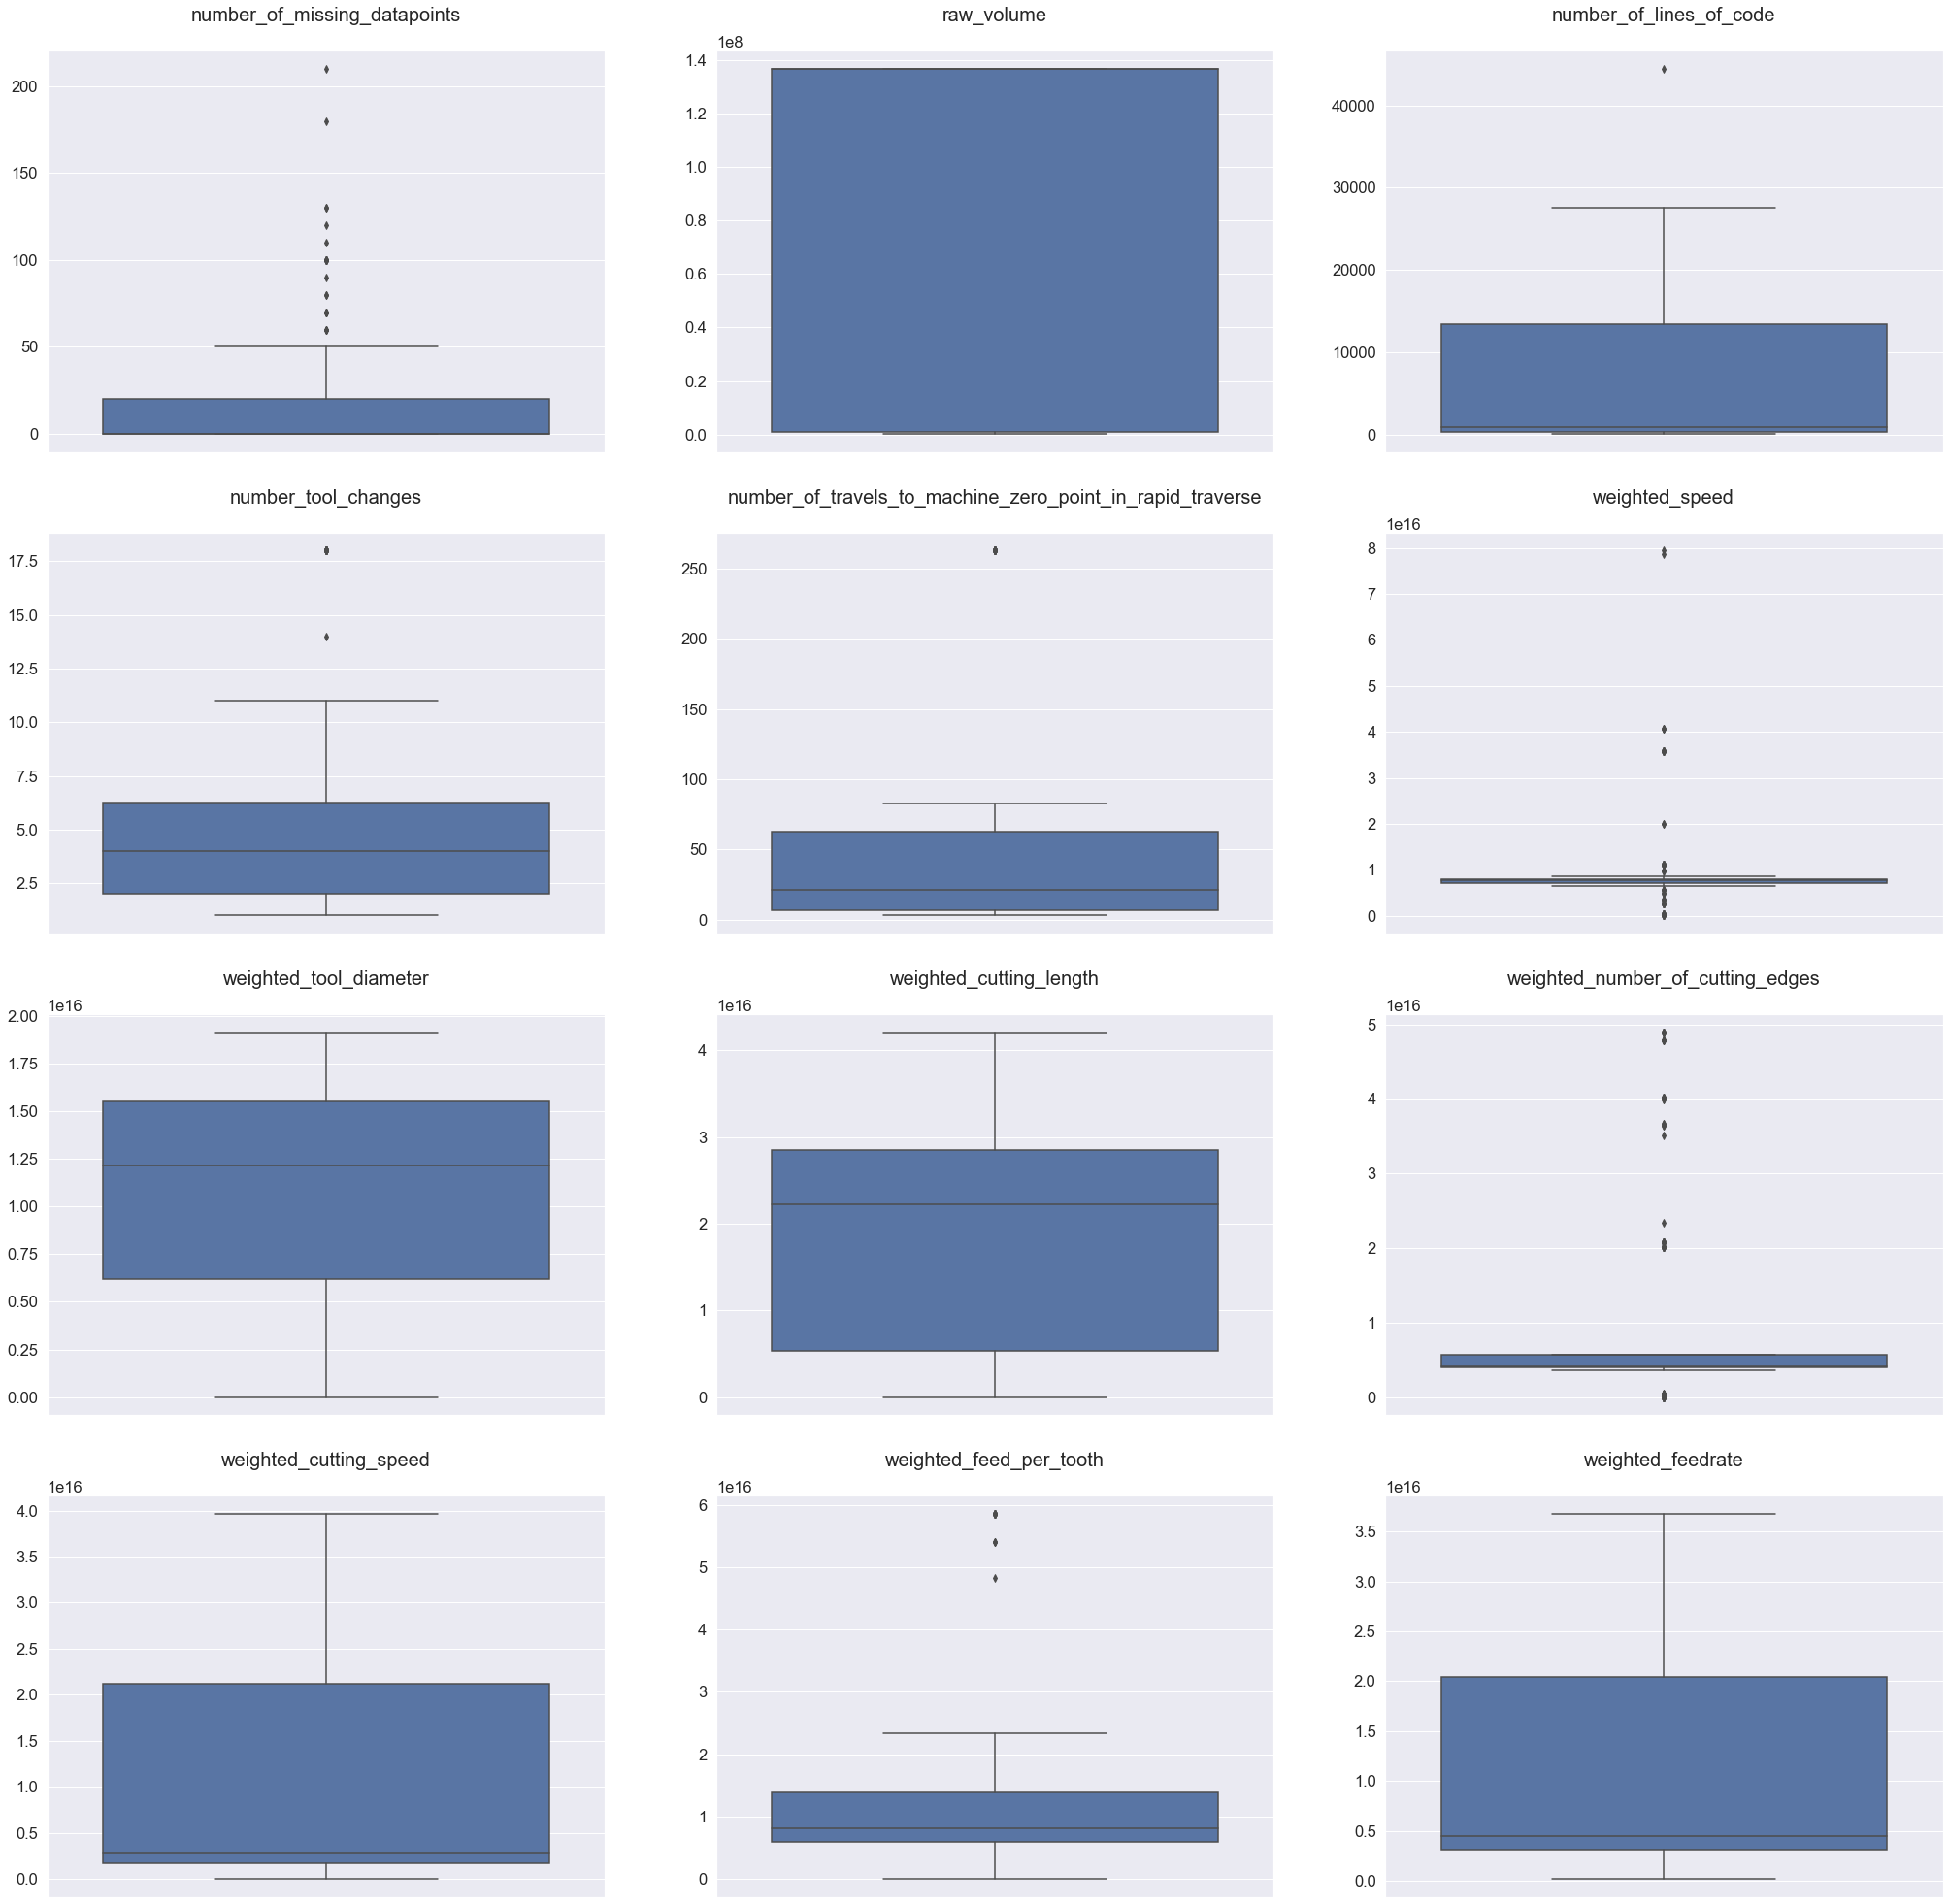

In [139]:
# boxplot of the standardised features
plot_boxplot(reduced_df_standardised, 4, 3)

Now, as seen from the above boxplots, the data does not lie within the range of [0,1], but, they all lie within the same range of scale.
- however, still the features with outliers are squeezed within a short range.

### Standardisation using RobustScaler()

In [140]:
# initialise RobustScaler()
robust_scaler = RobustScaler().fit(Xvar_df)

# transform the dataset
robust_data = robust_scaler.transform(Xvar_df)

# build a dataframe from the returned ndarray
reduced_df_robust = pd.DataFrame(data=robust_data, columns=Xvar_df.columns)
reduced_df_robust.head()

,number_of_missing_datapoints,raw_volume,number_of_lines_of_code,number_tool_changes,number_of_travels_to_machine_zero_point_in_rapid_traverse,weighted_speed,weighted_tool_diameter,weighted_cutting_length,weighted_number_of_cutting_edges,weighted_cutting_speed,weighted_feed_per_tooth,weighted_feedrate
0,0.0,0.000000,0.368547,0.235294,-0.178571,77.490759,0.404956,-0.772803,-0.089421,0.060349,0.473713,1.869093
1,0.0,0.000000,-0.038564,0.000000,-0.142857,76.643984,-1.179787,0.245979,0.033084,1.317192,-0.315969,-0.245193
2,0.5,-1.003352,-0.055924,-0.470588,-0.285714,-0.551965,0.000000,-0.732060,-0.029161,-0.062353,-0.110720,0.924168
3,0.0,-1.003352,-0.055924,-0.470588,-0.285714,-0.551965,0.000000,-0.732060,-0.029161,-0.062353,-0.110720,0.924168
4,0.0,-1.003352,-0.055924,-0.470588,-0.285714,-0.551965,0.000000,-0.732060,-0.029161,-0.062353,-0.110720,0.924168


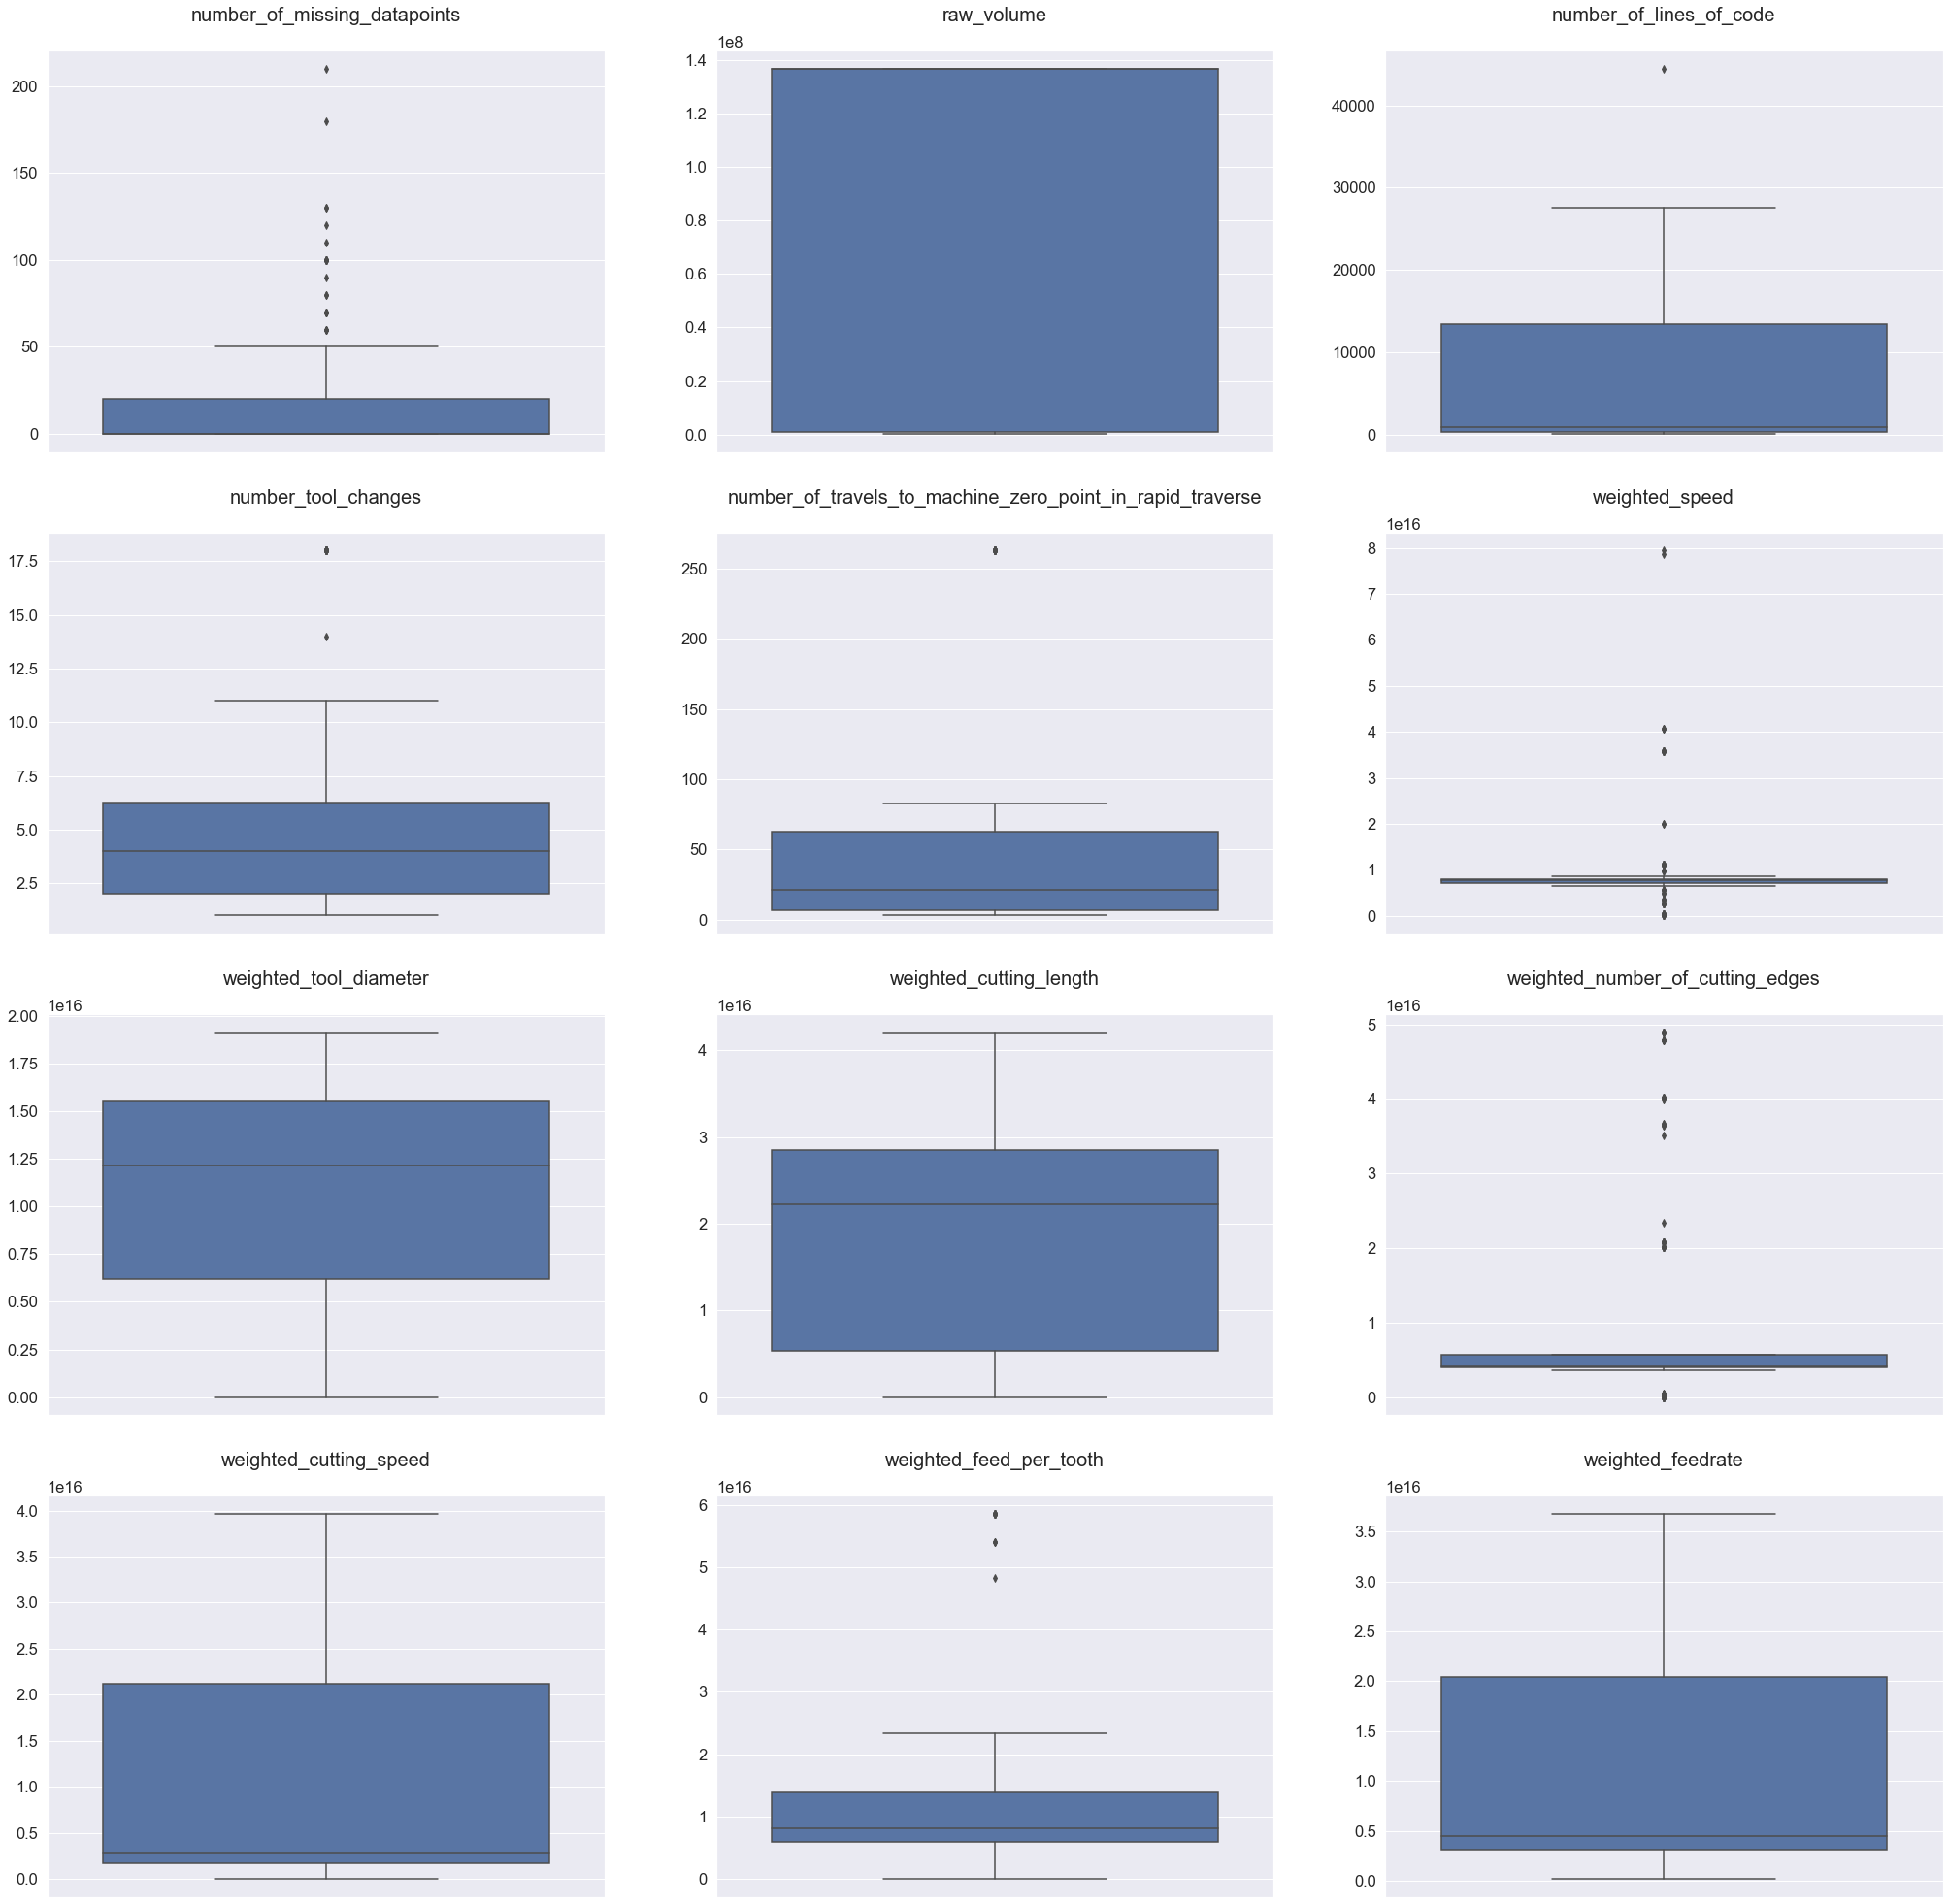

In [141]:
# boxplot of the standardised features
plot_boxplot(reduced_df_robust, 4, 3)

Now, as seen from the above boxplots, all the data do not lie within the same range of scale.
- and the features with outliers are squeezed within a short range.

We can use `MinMaxScaler()` for our analysis here.

### Predict Processing Time and Average Power Consumption using Regression Methods

#### Predict Processing Time

In [354]:
def prepare_train_test_data(data_frame, tartget_feaute):
    
    # Seperate the Independent and Dependent variables
    # Here Processing Time is Dependent/Target variable which we want to predict
    # Rest are Independent variables
    df_X = data_frame.loc[:, ~data_frame.columns.isin([tartget_feaute])]
    df_y = data_frame[[tartget_feaute]]
    print(f'Input DataFrame shape: {df_X.shape}, and Output DataFrameshape: {df_y.shape}', '\n')

    # Split data set into train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size = 0.20, random_state=42, shuffle=True)

    # As we have seen in histogram, Data do not have normal distribution
    # Hence, Normalise the data for better prediction
    # Initialise scaler for Normalisation
    scalerX = StandardScaler()

    # Normalise the Training input data set
    X_train_scaled = scalerX.fit_transform(X_train)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

    # Normalise the Test input data set
    X_test_scaled = scalerX.fit_transform(X_test)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_train.columns)

    print(f'Training Input Data set shape: {X_train_scaled.shape}, and Test Input Data set shape: {X_test_scaled.shape}', '\n')
    
    return X_train_scaled, y_train, X_test_scaled, y_test

In [360]:
def check_model_quality(model, X_train, y_train, y_test, y_pred):

    # R square val
    r_squared = round(model.score(X_train, y_train.values), 3)
    print(f'coefficient of determination(R^2) is: {r_squared}')

    # Check Mean Squared Error, Root Mean Squared Error and Mean Absolute Error
    mse = round(mean_squared_error(y_test, y_pred), 3)
    print(f'Mean Squared Error(MSE) is: {mse}')

    rmse = round(np.sqrt(mse), 3)
    print(f'Root Mean Squared Error(RMSE) is: {rmse}')

    mae = round(mean_absolute_error(y_test, y_pred), 3)
    print(f'Mean Absolute Error(MAE) is: {mae}')


    num_params = X_train_scaled.shape[1]
    n = X_train_scaled.shape[0]

    # calculate aic for regression
    aic = round(- 2 * math.log(mse) + 2 * num_params, 3)
    print(f'Akaike Information Criterion(AIC) is: {aic}')

    # calculate bic for regression
    bic = round(- 2 * math.log(mse) + num_params * math.log(n), 3)
    print(f'Bayesian Information Criterion(BIC) is: {bic}')
    
    return r_squared, mse, rmse, mae, aic, bic

In [361]:
def plot_results(y_test, y_pred):
    
    plt.plot(y_test, 'o', label='Processing Time')
    plt.plot(y_pred, '*r', label='Predicted_Processing Time')
    plt.ylabel('Processing Time')
    plt.xlabel('Observation Number')
    plt.legend()
    plt.show()

In [362]:
model_quality_stats = []

### 1. Multiple Linear Regression

In [363]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data(df_final, 'processing_time')

Input DataFrame shape: (220, 9), and Output DataFrameshape: (220, 1) 

Training Input Data set shape: (176, 9), and Test Input Data set shape: (44, 9) 



#### Build and Fit the Model:

In [364]:
# Building model with Scikit Learn
multi_linear_reg_model = LinearRegression()

# Train the model
multi_linear_reg_model = multi_linear_reg_model.fit(X_train_scaled, y_train)

# Predict processing time
y_pred = multi_linear_reg_model.predict(X_test_scaled)

In [365]:
print(f'Number of features are seen during trainin: {multi_linear_reg_model.n_features_in_}', '\n')

# Coefficient for independent var
print(f'Coefficient for independent var:')
for i, coef in enumerate(multi_linear_reg_model.coef_[0]):
    print(f'{df_final.columns[i]} : {coef}')

# intercept 
print(f'\nIntercept: {multi_linear_reg_model.intercept_}')

Number of features are seen during trainin: 9 

Coefficient for independent var:
processing_time : -0.6440990230392443
average_power_consumption : -75.4662324705887
raw_volume : 262.41831838274334
number_of_lines_of_code : 257.67737326231446
number_tool_changes : 1082.0815234322272
number_of_travels_to_machine_zero_point_in_rapid_traverse : 29.15488191128875
weighted_tool_diameter : -71.5742935273942
weighted_cutting_length : 40.99637686220894
weighted_number_of_cutting_edges : 83.4849423360013

Intercept: [1005.3125]


In [367]:
multi_linear_reg_model_r_squared, \
multi_linear_reg_model_mse, \
multi_linear_reg_model_rmse, \
multi_linear_reg_model_mae, \
multi_linear_reg_model_aic, \
multi_linear_reg_model_bic = check_model_quality(multi_linear_reg_model, 
                                                          X_train_scaled, y_train, 
                                                          y_test, y_pred)

coefficient of determination(R^2) is: 0.973
Mean Squared Error(MSE) is: 23721.101
Root Mean Squared Error(RMSE) is: 154.017
Mean Absolute Error(MAE) is: 115.742
Akaike Information Criterion(AIC) is: -2.148
Bayesian Information Criterion(BIC) is: 26.386


In [368]:
model_quality_stats.append([multi_linear_reg_model_r_squared, 
                           multi_linear_reg_model_mse,
                           multi_linear_reg_model_rmse,
                           multi_linear_reg_model_mae, 
                           multi_linear_reg_model_aic, 
                           multi_linear_reg_model_bic])

#### Check the Quality of the Model:

In [369]:
# Test Model with the K-Folds validation
cv_val = cross_val_score(multi_linear_reg_model, 
                               X_train_scaled, y_train, 
                               cv=10,  
                               scoring='neg_mean_squared_error')

print(f'Result of K-Folds cross validation: {-cv_val}')

Result of K-Folds cross validation: [ 58517.79805167  48813.4642119   74163.1812845   70797.47532529
  18495.84244429  33860.73386329  60150.45523449  36818.7664297
  48715.15720256 248664.75685275]


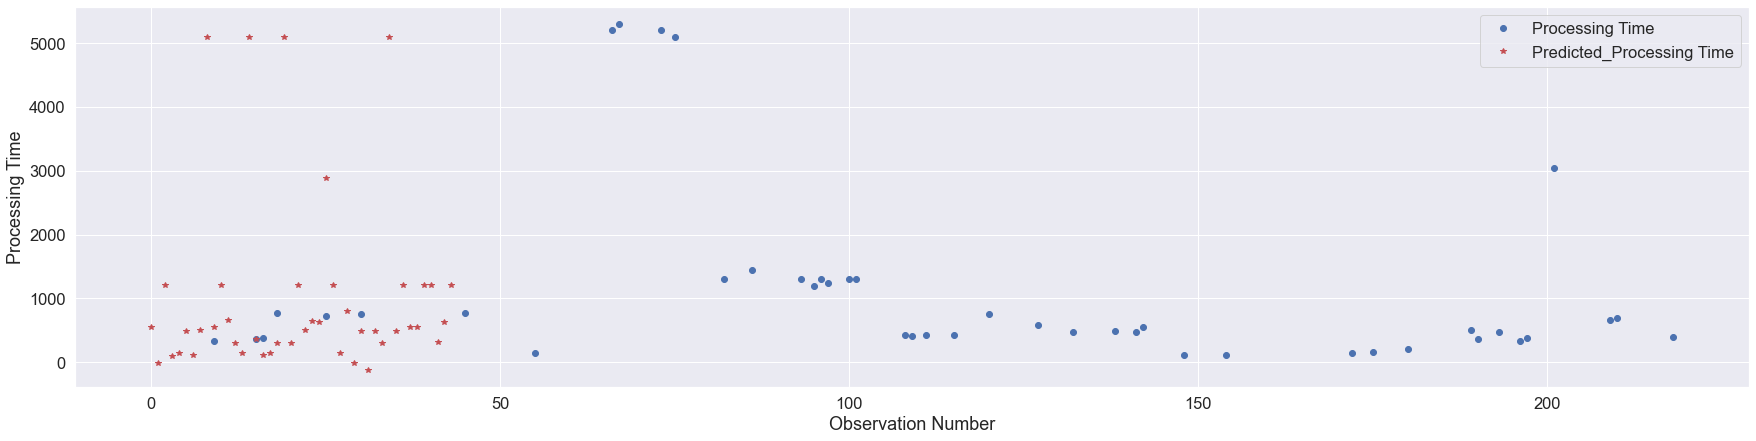

In [370]:
plot_results(y_test, y_pred)

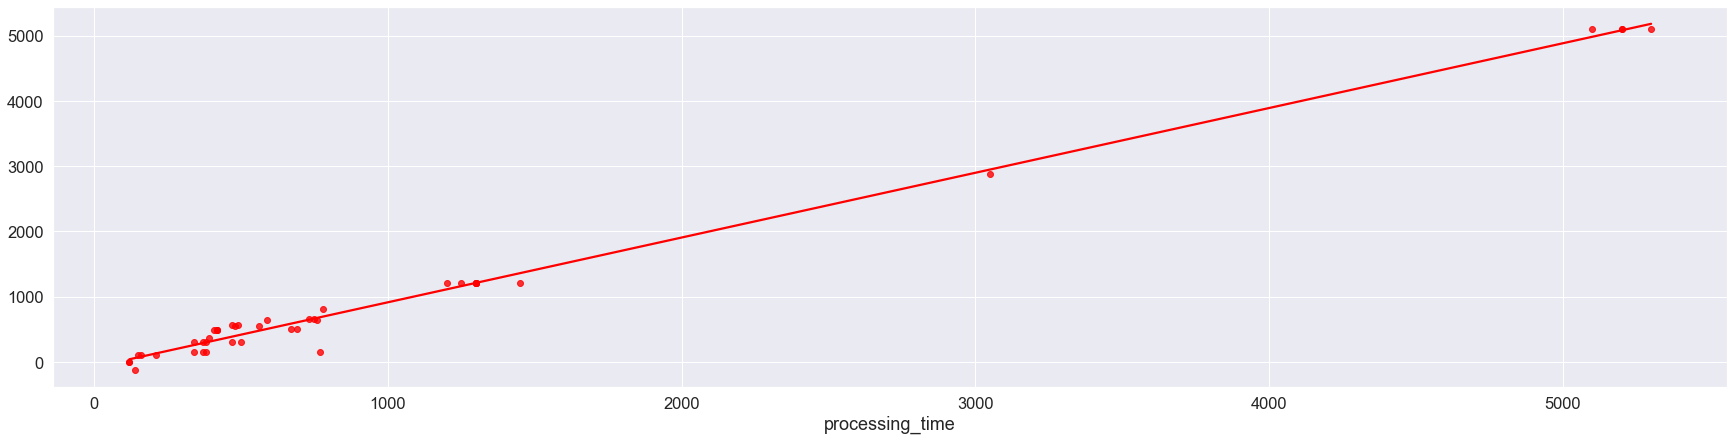

In [371]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

#### Optimize The Model with Backward Elimination:

In [372]:
ml_reg_model = sm.OLS(y_train, X_train_scaled)
ml_reg_model = ml_reg_model.fit()
ml_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        processing_time   R-squared (uncentered):                   0.662
Model:                            OLS   Adj. R-squared (uncentered):              0.644
Method:                 Least Squares   F-statistic:                              36.36
Date:                Tue, 29 Nov 2022   Prob (F-statistic):                    5.46e-35
Time:                        16:53:03   Log-Likelihood:                         -1471.4
No. Observations:                 176   AIC:                                      2961.
Df Residuals:                     167   BIC:                                      2989.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6441     85.599     -0.008      0.994    -169.640     168.352
x2           -75.4662    106.199     -0.711      0.478    -285.132     134.200
x3           262.4183    140.141      1.873      0.063     -14.258     539.094
x4           257.6774    148.622      1.734      0.085     -35.742     551.097
x5          1082.0815    214.968      5.034      0.000     657.676    1506.487
x6            29.1549     95.865      0.304      0.761    -160.109     218.418
x7           -71.5743    102.486     -0.698      0.486    -273.910     130.761
x8            40.9964     98.630      0.416      0.678    -153.726     235.719
x9            83.4849     93.235      0.895      0.372    -100.586     267.556
==============================================================================
Omnibus:                      111.842   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1110.916
Skew:                           2.181   Prob(JB):                    5.86e-242
Kurtosis:                      14.509   Cond. No.                         5.96
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [373]:
# add the dummy variable ( X-zero) and set the values to ones
X_train_scaled = sm.add_constant(X_train_scaled)
X_opt = X_train_scaled[:,list(np.arange(0, 12))]

IndexError: index 10 is out of bounds for axis 1 with size 10

In [ ]:
model = sm.OLS(y_train, X_opt).fit()
model.summary()

In [ ]:
# Remove variable for which p>0.05
# Hence remove x9, x13
X_opt = X_train_scaled[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]]

model=sm.OLS(y_train, X_opt).fit()
model.summary()

In [ ]:
#Rebuilding the model after removing the variable
multi_linear_opt_reg_model = LinearRegression()
multi_linear_opt_reg_model = multi_linear_opt_reg_model.fit(X_opt, y_train)

# Predict test set result
y_pred = multi_linear_opt_reg_model.predict(X_test_scaled[:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]])

In [374]:
multi_linear_opt_reg_model_r_squared, \
multi_linear_opt_reg_model_mse, \
multi_linear_opt_reg_model_rmse, \
multi_linear_opt_reg_model_mae, \
multi_linear_opt_reg_model_aic, \
multi_linear_opt_reg_model_bic = check_model_quality(multi_linear_opt_reg_model, 
                                                          X_opt, y_train, 
                                                          y_test, y_pred)

coefficient of determination(R^2) is: 0.972
Mean Squared Error(MSE) is: 23721.101
Root Mean Squared Error(RMSE) is: 154.017
Mean Absolute Error(MAE) is: 115.742
Akaike Information Criterion(AIC) is: -0.148
Bayesian Information Criterion(BIC) is: 31.557


In [375]:
model_quality_stats.append([multi_linear_opt_reg_model_r_squared, \
                            multi_linear_opt_reg_model_mse, \
                            multi_linear_opt_reg_model_rmse, \
                            multi_linear_opt_reg_model_mae, \
                            multi_linear_opt_reg_model_aic, \
                            multi_linear_opt_reg_model_bic])

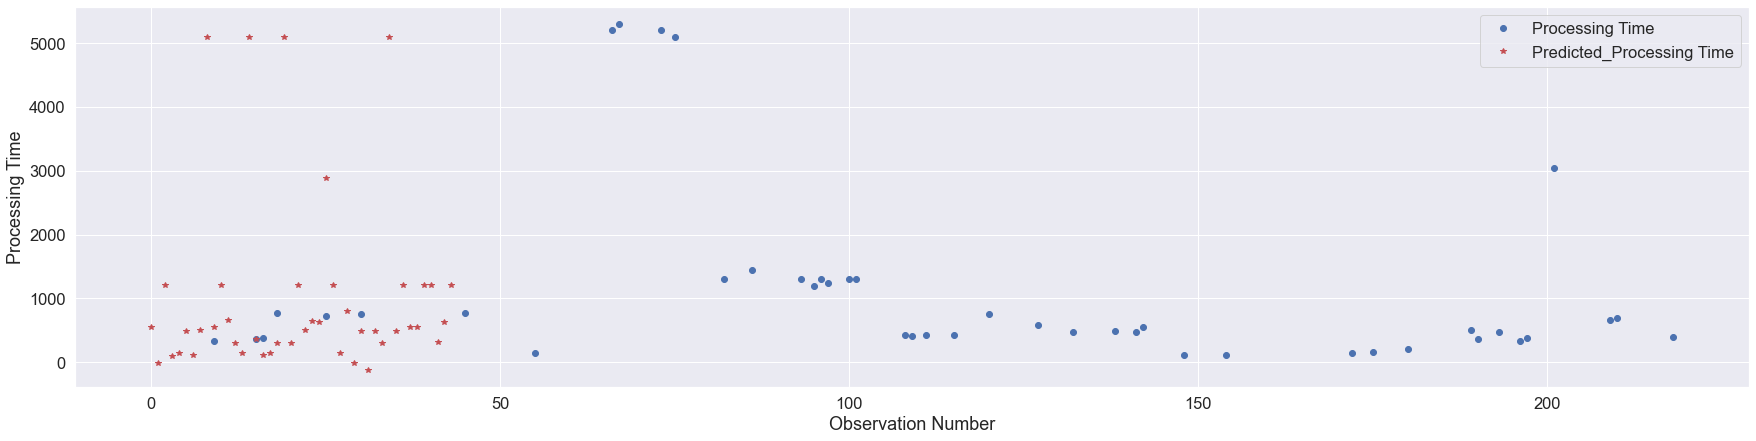

In [376]:
plot_results(y_test, y_pred)

From the above results, we can see that as we removed the variables for which p>0.5 then ${R}^2$ decrease and also AIC and BIC increase.

Hence, model with all variable is good fit comparatively. 

### ? Not sure about this

### 2. Polynomial Regression

In [377]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data(df_final, 'processing_time')

Input DataFrame shape: (220, 9), and Output DataFrameshape: (220, 1) 

Training Input Data set shape: (176, 9), and Test Input Data set shape: (44, 9) 



In [378]:
poly_reg = PolynomialFeatures(degree=4)
X_train_poly = poly_reg.fit_transform(X_train_scaled)
X_test_poly = poly_reg.fit_transform(X_test_scaled)

poly_reg_model = LinearRegression()
poly_reg_model = poly_reg_model.fit(X_train_poly, y_train)

y_pred = poly_reg_model.predict(X_test_poly)

In [379]:
poly_reg_model_r_squared, \
poly_reg_model_mse, \
poly_reg_model_rmse, \
poly_reg_model_mae, \
poly_reg_model_aic, \
poly_reg_model_bic = check_model_quality(poly_reg_model, X_train_poly, y_train, y_test, y_pred)

coefficient of determination(R^2) is: 0.998
Mean Squared Error(MSE) is: 2.8230677249352294e+27
Root Mean Squared Error(RMSE) is: 53132548639560.19
Mean Absolute Error(MAE) is: 19945885306619.652
Akaike Information Criterion(AIC) is: -108.415
Bayesian Information Criterion(BIC) is: -79.881


In [380]:
model_quality_stats.append([poly_reg_model_r_squared, \
                            poly_reg_model_mse, \
                            poly_reg_model_rmse, \
                            poly_reg_model_mae, \
                            poly_reg_model_aic, \
                            poly_reg_model_bic])

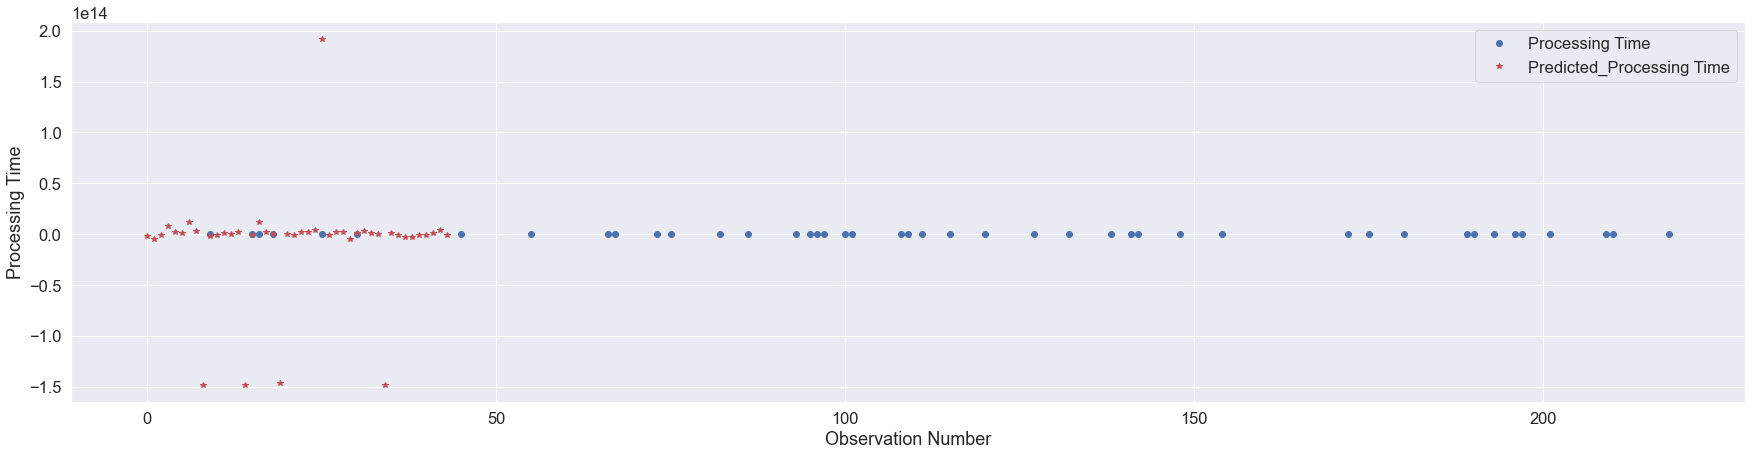

In [381]:
plot_results(y_test, y_pred)

### 3. Lasso, Ridge and Elastic Net Regression:

**LASSO (L1 regularization)**

    - regularization term penalizes absolute value of the coefficients
    - sets irrelevant values to 0
    - might remove too many features in our model

**Ridge Regression (L2 regularization)**

    - penalizes the size (square of the magnitude) of the regression coefficients
    - enforces the B (slope/partial slope) coefficients to be lower, but not 0
    - does not remove irrelevant features, but minimizes their impact

**Elastic Net Regression**
    
    - It takes advantage of LASSO and Ridge.

Ref: https://towardsdatascience.com/ridge-lasso-and-elasticnet-regression-b1f9c00ea3a3

### Lasso Regression:

In [382]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data(df_final, 'processing_time')

Input DataFrame shape: (220, 9), and Output DataFrameshape: (220, 1) 

Training Input Data set shape: (176, 9), and Test Input Data set shape: (44, 9) 



In [383]:
# Find the best hyper parameter
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)

# Define model
lasso_reg_model = LassoCV(alphas=np.arange(0.1, 1, 0.01), cv=cv)

# Fit model
lasso_reg_model.fit(X_train_scaled, y_train)

# Get best hyper parameter
alpha = round(lasso_reg_model.alpha_, 4)
print(f'Best alpha for Lasso Regression Model is: {alpha}')

/Users/ebankadb/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha for Lasso Regression Model is: 0.99


In [384]:
# Define model
lasso_reg_model = Lasso(alpha = alpha)

# Fit model
lasso_reg_model.fit(X_train_scaled, y_train)

# Predict using model
y_pred = lasso_reg_model.predict(X_test_scaled)

In [385]:
lasso_reg_model_r_squared, \
lasso_reg_model_mse, \
lasso_reg_model_rmse, \
lasso_reg_model_mae, \
lasso_reg_model_aic, \
lasso_reg_model_bic = check_model_quality(lasso_reg_model, X_train_scaled, y_train, y_test, y_pred)

coefficient of determination(R^2) is: 0.973
Mean Squared Error(MSE) is: 23889.55
Root Mean Squared Error(RMSE) is: 154.562
Mean Absolute Error(MAE) is: 116.396
Akaike Information Criterion(AIC) is: -2.162
Bayesian Information Criterion(BIC) is: 26.372


In [386]:
model_quality_stats.append([lasso_reg_model_r_squared, \
                            lasso_reg_model_mse, \
                            lasso_reg_model_rmse, \
                            lasso_reg_model_mae, \
                            lasso_reg_model_aic, \
                            lasso_reg_model_bic])

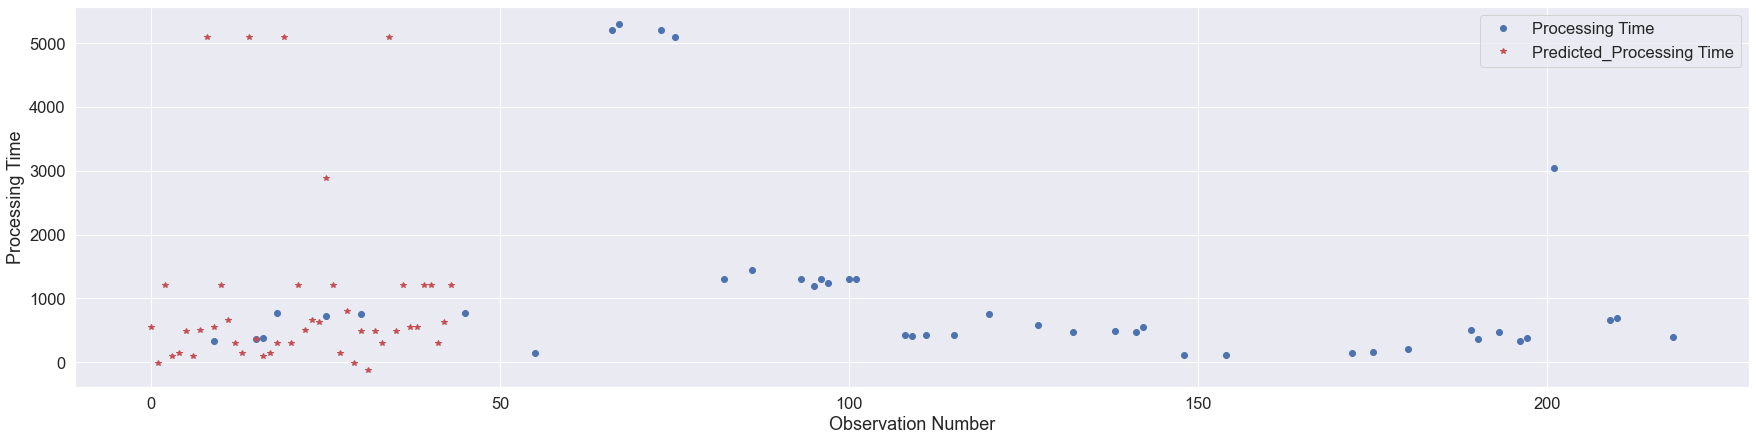

In [387]:
plot_results(y_test, y_pred)

### Ridge Regression:

In [388]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data(df_final, 'processing_time')

Input DataFrame shape: (220, 9), and Output DataFrameshape: (220, 1) 

Training Input Data set shape: (176, 9), and Test Input Data set shape: (44, 9) 



In [389]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define model
ridge_reg_model = RidgeCV(alphas=np.arange(0.01, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')

# Fit model
ridge_reg_model.fit(X_train_scaled, y_train)

# Get the best hyper parameter
alpha = ridge_reg_model.alpha_
print(f'Best alpha for Ridge Regression Model is: {alpha}')

Best alpha for Ridge Regression Model is: 0.99


In [390]:
# Define model
ridge_reg_model = Ridge(alpha = alpha)

# Fit model
ridge_reg_model.fit(X_train_scaled, y_train)

# Predict using model
y_pred = ridge_reg_model.predict(X_test_scaled)

In [391]:
ridge_reg_model_r_squared, \
ridge_reg_model_mse, \
ridge_reg_model_rmse, \
ridge_reg_model_mae, \
ridge_reg_model_aic, \
ridge_reg_model_bic = check_model_quality(ridge_reg_model, X_train_scaled, y_train, y_test, y_pred)

coefficient of determination(R^2) is: 0.972
Mean Squared Error(MSE) is: 23798.162
Root Mean Squared Error(RMSE) is: 154.267
Mean Absolute Error(MAE) is: 115.642
Akaike Information Criterion(AIC) is: -2.155
Bayesian Information Criterion(BIC) is: 26.38


In [392]:
model_quality_stats.append([ridge_reg_model_r_squared, \
                            ridge_reg_model_mse, \
                            ridge_reg_model_rmse, \
                            ridge_reg_model_mae, \
                            ridge_reg_model_aic, \
                            ridge_reg_model_bic])

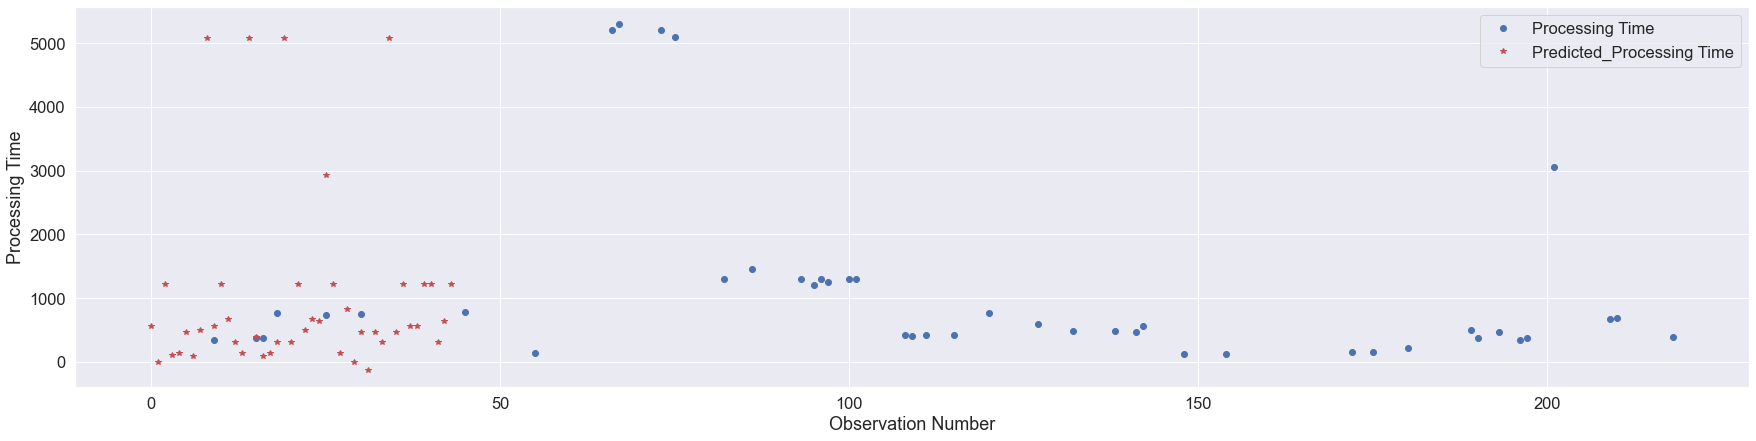

In [393]:
plot_results(y_test, y_pred)

### Elastic Net Regression:

In [394]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data(df_final, 'processing_time')

Input DataFrame shape: (220, 9), and Output DataFrameshape: (220, 1) 

Training Input Data set shape: (176, 9), and Test Input Data set shape: (44, 9) 



In [395]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define Model
ratios = np.arange(0.01, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
elastic_net_reg_model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv)

# Fit model
elastic_net_reg_model.fit(X_train_scaled, y_train)

# Get the best hyper parameter
alpha = elastic_net_reg_model.alpha_
l1_ratio = elastic_net_reg_model.l1_ratio_
print(f'Best alpha for Elastic Net Regression Model is: {alpha}')
print(f'Best l1_ratio for Elastic Net Regression Model is: {l1_ratio}')

/Users/ebankadb/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha for Elastic Net Regression Model is: 0.1
Best l1_ratio for Elastic Net Regression Model is: 0.9600000000000001


In [398]:
# Define model
elastic_net_reg_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

# Fit model
elastic_net_reg_model.fit(X_train_scaled, y_train)

# Predict using model
y_pred = elastic_net_reg_model.predict(X_test_scaled)

In [399]:
elastic_net_reg_model_r_squared, \
elastic_net_reg_model_mse, \
elastic_net_reg_model_rmse, \
elastic_net_reg_model_mae, \
elastic_net_reg_model_aic, \
elastic_net_reg_model_bic = check_model_quality(elastic_net_reg_model, X_train_scaled, y_train, y_test, y_pred)

coefficient of determination(R^2) is: 0.973
Mean Squared Error(MSE) is: 23754.74
Root Mean Squared Error(RMSE) is: 154.126
Mean Absolute Error(MAE) is: 115.669
Akaike Information Criterion(AIC) is: -2.151
Bayesian Information Criterion(BIC) is: 26.383


In [400]:
model_quality_stats.append([elastic_net_reg_model_r_squared, \
                            elastic_net_reg_model_mse, \
                            elastic_net_reg_model_rmse, \
                            elastic_net_reg_model_mae, \
                            elastic_net_reg_model_aic, \
                            elastic_net_reg_model_bic])

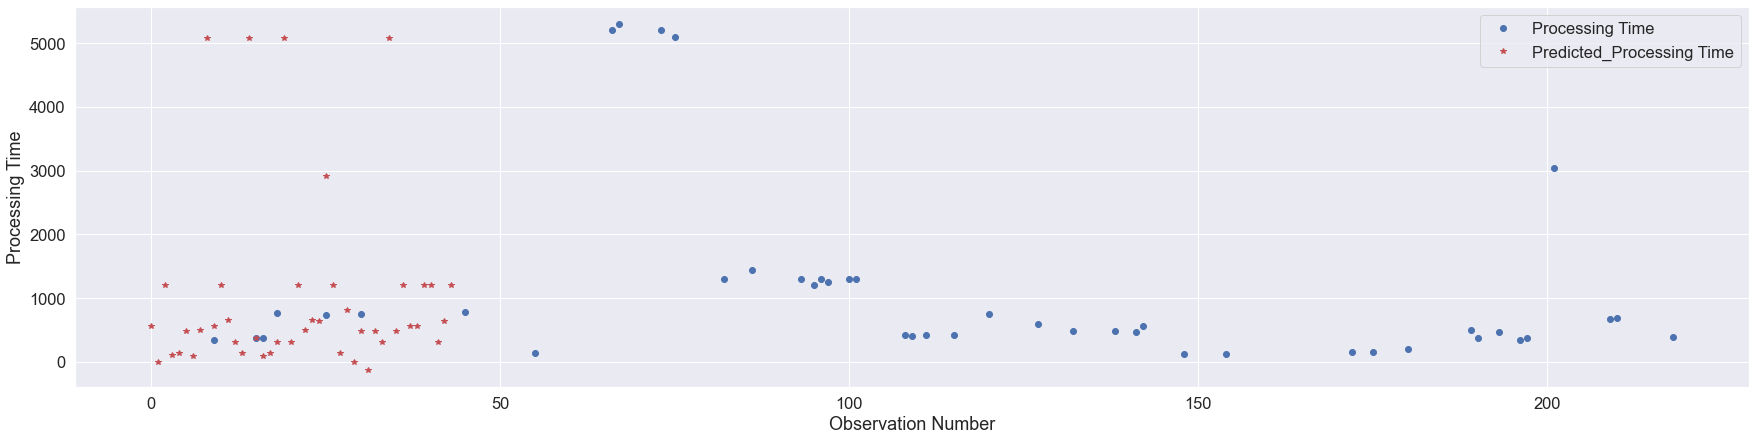

In [401]:
plot_results(y_test, y_pred)

### 4.Decision Tree Regression

In [402]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data(df_final, 'processing_time')

Input DataFrame shape: (220, 9), and Output DataFrameshape: (220, 1) 

Training Input Data set shape: (176, 9), and Test Input Data set shape: (44, 9) 



In [403]:
# Hyper parameters range intialization for tuning 
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
            "min_samples_leaf":[1, 3, 5, 7, 10],
            "min_weight_fraction_leaf":[0.1, 0.2, 0.3, 0.4, 0.5],
            "max_features":[1.0,"log2","sqrt"],
            "max_leaf_nodes":[None, 10, 30, 50, 70,90]}

In [404]:
# Define decision regression tree model
decision_tree_reg_model=DecisionTreeRegressor()

# Tune the decision tree model
tuning_model=GridSearchCV(decision_tree_reg_model, param_grid=parameters, scoring='neg_mean_squared_error',cv=5)
tuning_model.fit(X_train_scaled, y_train)

tuning_model.best_params_

{'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': 70,
 'min_samples_leaf': 5,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [405]:
# Tune the model with the best hyper parameters
decision_tree_reg_tuned= DecisionTreeRegressor(max_depth=5,
                                               max_features=1.0,
                                               max_leaf_nodes=None,
                                               min_samples_leaf=1,
                                               min_weight_fraction_leaf=0.1,
                                               splitter='best')

# Fit the model
decision_tree_reg_tuned.fit(X_train_scaled,y_train)

# Make prediction
y_pred = decision_tree_reg_tuned.predict(X_test_scaled)

In [406]:
decision_tree_reg_model_r_squared, \
decision_tree_reg_model_mse, \
decision_tree_reg_model_rmse, \
decision_tree_reg_model_mae, \
decision_tree_reg_model_aic, \
decision_tree_reg_model_bic = check_model_quality(decision_tree_reg_tuned, X_train_scaled, y_train, y_test, y_pred)



coefficient of determination(R^2) is: 0.883
Mean Squared Error(MSE) is: 1416292.391
Root Mean Squared Error(RMSE) is: 1190.081
Mean Absolute Error(MAE) is: 510.578
Akaike Information Criterion(AIC) is: -10.327
Bayesian Information Criterion(BIC) is: 18.207


In [407]:
model_quality_stats.append([decision_tree_reg_model_r_squared, \
                            decision_tree_reg_model_mse, \
                            decision_tree_reg_model_rmse, \
                            decision_tree_reg_model_mae, \
                            decision_tree_reg_model_aic, \
                            decision_tree_reg_model_bic])

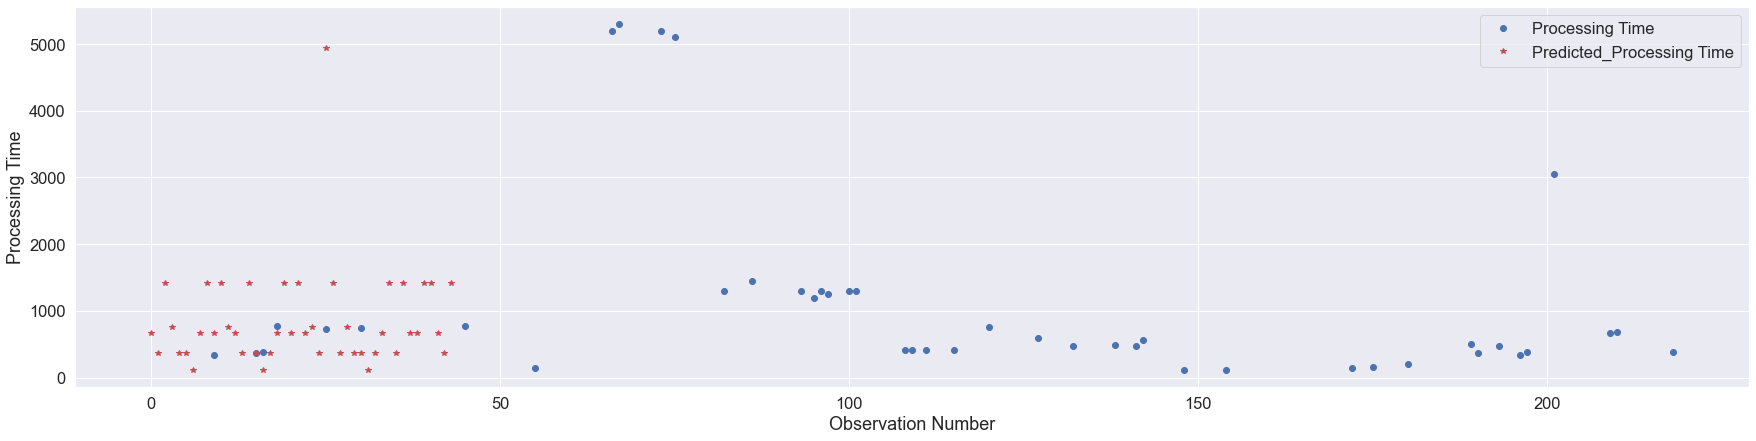

In [408]:
plot_results(y_test, y_pred)

### 5. Random Forest Regression

In [432]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data(df_final, 'processing_time')

Input DataFrame shape: (220, 9), and Output DataFrameshape: (220, 1) 

Training Input Data set shape: (176, 9), and Test Input Data set shape: (44, 9) 



In [433]:
# Hyper parameters range intialization for tuning 
space = {'n_estimators': hp.uniform('n_estimators',100,500),
           'max_features': hp.choice('max_features', [1.0, 'sqrt', 'log2']),
           'max_depth' : hp.uniform('max_depth',5,20),
           'min_samples_split': hp.uniform('min_samples_split',2,15),
           'min_samples_leaf': hp.uniform('min_samples_leaf',1,10),
           'bootstrap': hp.choice('bootstrap', [True, False])}

In [434]:
def tuneHyperparameters_RandonForest(space):
          
    # Initialise xgboost model
    random_forest_reg_model = RandomForestRegressor(
                                                n_estimators = int(space['n_estimators']),
                                                max_features = space['max_features'],
                                                max_depth = int(space['max_depth']),
                                                min_samples_split = int(space['min_samples_split']),
                                                min_samples_leaf = int(space['min_samples_leaf']),
                                                bootstrap = space['bootstrap']
                                                )

    # Train the model
    random_forest_reg_model.fit(X_train_scaled, y_train)
    
    # Forecaste the traget variable
    y_pred = random_forest_reg_model.predict(X_test_scaled)
    
    # Compute the error
    mse = mean_squared_error(y_test, y_pred)    
        
    return mse

In [435]:
# Fine tune the hyperparameters of the xgboost
trials = Trials()
best_hyperparams = fmin(
                        fn = tuneHyperparameters_RandonForest,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials
                       )

best_hyperparams

 10%|█         | 1/10 [00:00<00:02,  4.04trial/s, best loss: 200788.81044533045]

/var/folders/dc/5pxh5qn55zz_6g13wpy7yt380000gn/T/ipykernel_33314/2789230558.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_reg_model.fit(X_train_scaled, y_train)

/var/folders/dc/5pxh5qn55zz_6g13wpy7yt380000gn/T/ipykernel_33314/2789230558.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_reg_model.fit(X_train_scaled, y_train)


 30%|███       | 3/10 [00:00<00:01,  3.88trial/s, best loss: 147077.14907820604]


/var/folders/dc/5pxh5qn55zz_6g13wpy7yt380000gn/T/ipykernel_33314/2789230558.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_reg_model.fit(X_train_scaled, y_train)

/var/folders/dc/5pxh5qn55zz_6g13wpy7yt380000gn/T/ipykernel_33314/2789230558.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_reg_model.fit(X_train_scaled, y_train)



 40%|████      | 4/10 [00:01<00:01,  3.44trial/s, best loss: 147077.14907820604]

/var/folders/dc/5pxh5qn55zz_6g13wpy7yt380000gn/T/ipykernel_33314/2789230558.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_reg_model.fit(X_train_scaled, y_train)



 50%|█████     | 5/10 [00:01<00:01,  2.52trial/s, best loss: 101494.01341973018]

/var/folders/dc/5pxh5qn55zz_6g13wpy7yt380000gn/T/ipykernel_33314/2789230558.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_reg_model.fit(X_train_scaled, y_train)



 70%|███████   | 7/10 [00:02<00:00,  3.20trial/s, best loss: 101494.01341973018]

/var/folders/dc/5pxh5qn55zz_6g13wpy7yt380000gn/T/ipykernel_33314/2789230558.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_reg_model.fit(X_train_scaled, y_train)



 80%|████████  | 8/10 [00:02<00:00,  3.26trial/s, best loss: 101494.01341973018]

/var/folders/dc/5pxh5qn55zz_6g13wpy7yt380000gn/T/ipykernel_33314/2789230558.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_reg_model.fit(X_train_scaled, y_train)

/var/folders/dc/5pxh5qn55zz_6g13wpy7yt380000gn/T/ipykernel_33314/2789230558.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_reg_model.fit(X_train_scaled, y_train)



 90%|█████████ | 9/10 [00:02<00:00,  3.18trial/s, best loss: 101494.01341973018]

/var/folders/dc/5pxh5qn55zz_6g13wpy7yt380000gn/T/ipykernel_33314/2789230558.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_reg_model.fit(X_train_scaled, y_train)



100%|█████████| 10/10 [00:03<00:00,  3.16trial/s, best loss: 101494.01341973018]


{'bootstrap': 0,
 'max_depth': 16.019569549627377,
 'max_features': 0,
 'min_samples_leaf': 5.932480970745818,
 'min_samples_split': 7.815968530288319,
 'n_estimators': 470.69372635720896}

In [436]:
# Tune the model with the best hyper parameters
random_forest_reg_model= RandomForestRegressor(
                                            n_estimators=int(best_hyperparams['n_estimators']),
                                            max_depth=int(best_hyperparams['max_depth']),
                                            max_features=best_hyperparams['max_features'],
                                            min_samples_split=int(best_hyperparams['min_samples_split']),
                                            min_samples_leaf=int(best_hyperparams['min_samples_leaf']),
                                            bootstrap=best_hyperparams['bootstrap'])

# Fit the model
random_forest_reg_model.fit(X_train_scaled,y_train)

# Make prediction
y_pred = random_forest_reg_model.predict(X_test_scaled)

/var/folders/dc/5pxh5qn55zz_6g13wpy7yt380000gn/T/ipykernel_33314/966474051.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_reg_model.fit(X_train_scaled,y_train)


ValueError: max_features == 0, must be >= 1.

In [429]:
random_forest_reg_model_r_squared, \
random_forest_reg_model_mse, \
random_forest_reg_model_rmse, \
random_forest_reg_model_mae, \
random_forest_reg_model_aic, \
random_forest_reg_model_bic = check_model_quality(random_forest_reg_model, X_train_scaled, y_train, y_test, y_pred)



coefficient of determination(R^2) is: 0.993
Mean Squared Error(MSE) is: 86862.247
Root Mean Squared Error(RMSE) is: 294.724
Mean Absolute Error(MAE) is: 163.779
Akaike Information Criterion(AIC) is: -4.744
Bayesian Information Criterion(BIC) is: 23.79


In [420]:
model_quality_stats.append([random_forest_reg_model_r_squared, \
                            random_forest_reg_model_mse, \
                            random_forest_reg_model_rmse, \
                            random_forest_reg_model_mae, \
                            random_forest_reg_model_aic, \
                            random_forest_reg_model_bic])

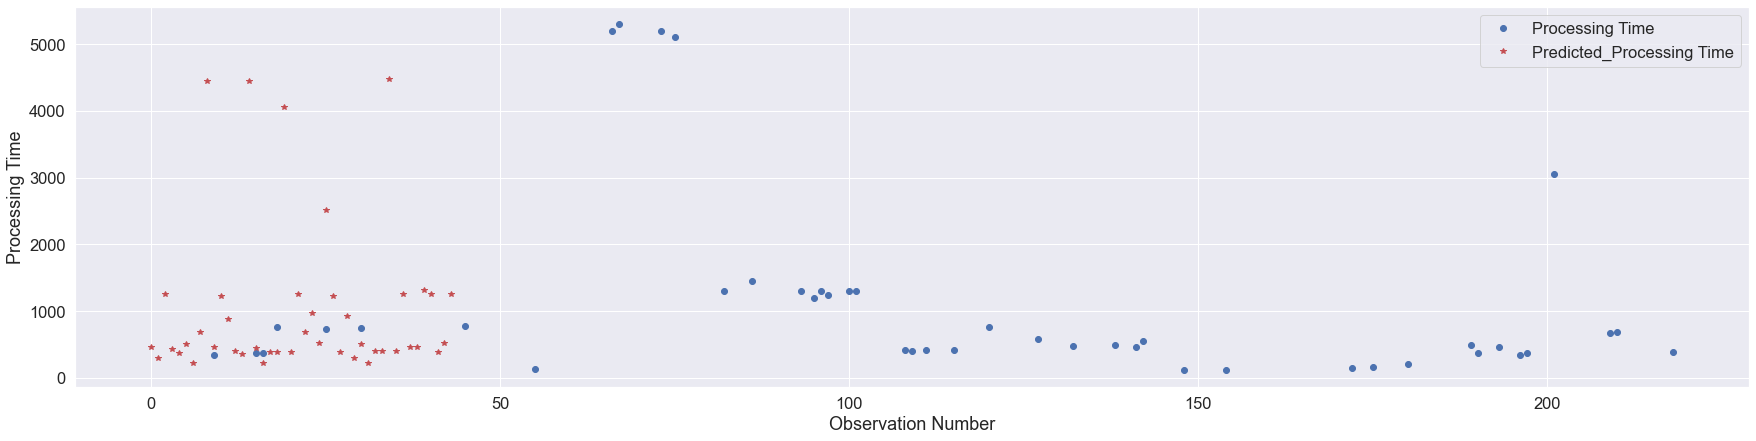

In [421]:
plot_results(y_test, y_pred)

### 6. Gradient Boosting Regression

In [437]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data(df_final, 'processing_time')

Input DataFrame shape: (220, 9), and Output DataFrameshape: (220, 1) 

Training Input Data set shape: (176, 9), and Test Input Data set shape: (44, 9) 



In [438]:
# Hyper parameters range intialization for tuning 
space = {'n_estimators': hp.uniform('n_estimators',100,500),
         'learning_rate': hp.uniform('learning_rate',0.001, 1.0),
         'min_samples_split': hp.uniform('min_samples_split', 2, 20),
         'min_samples_leaf': hp.uniform('min_samples_leaf', 1, 10),
         'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
         'max_depth' : hp.uniform('max_depth',5,20),
         'max_features': hp.choice('max_features', [1.0, 'sqrt', 'log2']),
         'alpha': hp.uniform('alpha',0.0, 1.0),
         'max_leaf_nodes': hp.uniform('max_leaf_nodes', 2, 10)
        }


In [439]:
def tuneHyperparameters_RandonForest(space):
          
    # Initialise xgboost model
    gradient_boost_reg_model = GradientBoostingRegressor(
                                                n_estimators = int(space['n_estimators']),
                                                learning_rate = space['learning_rate'],
                                                min_samples_split = int(space['min_samples_split']),
                                                min_samples_leaf = int(space['min_samples_leaf']),
                                                min_weight_fraction_leaf = space['min_weight_fraction_leaf'],
                                                max_depth = int(space['max_depth']),
                                                max_features = space['max_features'],
                                                alpha = space['alpha'],
                                                max_leaf_nodes = int(space['max_leaf_nodes'])
                                                )

    # Train the model
    gradient_boost_reg_model.fit(X_train_scaled, y_train)
    
    # Forecaste the traget variable
    y_pred = gradient_boost_reg_model.predict(X_test_scaled)
    
    # Compute the error
    mse = mean_squared_error(y_test, y_pred)    
        
    return mse

In [425]:
# Fine tune the hyperparameters of the xgboost
trials = Trials()
best_hyperparams = fmin(
                        fn = tuneHyperparameters_RandonForest,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials
                       )

best_hyperparams

 20%|██        | 2/10 [00:00<00:00, 13.12trial/s, best loss: 141794.44075406337]

/Users/ebankadb/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/Users/ebankadb/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/Users/ebankadb/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 40%|████      | 4/10 [00:00<00:00,  9.48trial/s, best loss: 141794.44075406337]

/Users/ebankadb/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/Users/ebankadb/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/Users/ebankadb/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 80%|████████  | 8/10 [00:00<00:00,  8.18trial/s, best loss: 141794.44075406337]

/Users/ebankadb/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/Users/ebankadb/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/Users/ebankadb/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



100%|██████████| 10/10 [00:01<00:00,  8.07trial/s, best loss: 83458.38870778604]


/Users/ebankadb/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



{'alpha': 0.8907995030776739,
 'learning_rate': 0.6752594615563766,
 'max_depth': 15.84206005331852,
 'max_features': 2,
 'max_leaf_nodes': 5.825677718056977,
 'min_samples_leaf': 1.842654038560266,
 'min_samples_split': 11.198744245638652,
 'min_weight_fraction_leaf': 0.08266579970879923,
 'n_estimators': 328.0778853986865}

In [ ]:
# Tune the model with the best hyper parameters
gradient_boosting_reg_model= GradientBoostingRegressor(
                                                    n_estimators=int(best_hyperparams['n_estimators']),
                                                    alpha=best_hyperparams['alpha'],
                                                    learning_rate=best_hyperparams['learning_rate'],
                                                    max_depth=int(best_hyperparams['max_depth']),
                                                    max_features=best_hyperparams['max_features'],
                                                    max_leaf_nodes=int(best_hyperparams['max_leaf_nodes']),
                                                    min_samples_split=int(best_hyperparams['min_samples_split']),
                                                    min_samples_leaf=int(best_hyperparams['min_samples_leaf']),
                                                    min_weight_fraction_leaf=best_hyperparams['min_weight_fraction_leaf']
                                                    )

# Fit the model
gradient_boosting_reg_model.fit(X_train_scaled,y_train)

# Make prediction
y_pred = gradient_boosting_reg_model.predict(X_test_scaled)

In [ ]:
gradient_boosting_reg_model_r_squared, \
gradient_boosting_reg_model_mse, \
gradient_boosting_reg_model_rmse, \
gradient_boosting_reg_model_mae, \
gradient_boosting_reg_model_aic, \
gradient_boosting_reg_model_bic = check_model_quality(gradient_boosting_reg_model, X_train_scaled, y_train, y_test, y_pred)



In [ ]:
model_quality_stats.append([gradient_boosting_reg_model_r_squared, \
                            gradient_boosting_reg_model_mse, \
                            gradient_boosting_reg_model_rmse, \
                            gradient_boosting_reg_model_mae, \
                            gradient_boosting_reg_model_aic, \
                            gradient_boosting_reg_model_bic])

In [ ]:
plot_results(y_test, y_pred)

### Compare Quality and Performance of the Regression Models to Predict Processing Time:

In [ ]:
index_list = ['multi_linear_reg_model',
              'multi_linear_reg_opt_model',
              'ploy_reg_mode',
              'lasso_reg_mode',
              'ridge_reg_mode',
              'elastic_net_reg_mode',
              'decision_tree_reg_model',
              'random_forest_reg_model',
              'gradient_boosting_reg_model']

columns_name = ['r_squared', 'mse', 'rmse', 'mae', 'aic', 'bic']

model_quality_df = pd.DataFrame(data=model_quality_stats, \
                                index=index_list,
                                columns=columns_name)

model_quality_df

---

### Average Power Consumption

In [ ]:
def prepare_train_test_data_reg():
    
    # Seperate the Independent and Dependent variables
    # Here Processing Time is Dependent/Target variable which we want to predict
    # Rest are Independent variables
    df_X = df.loc[:, ~df.columns.isin(['start_time', 'end_time', 'average_power_consumption'])]
    df_y = df[['average_power_consumption']]
    print(f'Input DataFrame shape: {df_X.shape}, and Output DataFrameshape: {df_y.shape}', '\n')

    # Split data set into train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size = 0.20, random_state=0, shuffle=True)

    # As we have seen in histogram, Data do not have normal distribution
    # Hence, Normalise the data for better prediction
    # Initialise scaler for Normalisation
    scalerX = StandardScaler()

    # Normalise the Training input data set
    X_train_scaled = scalerX.fit_transform(X_train)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

    # Normalise the Test input data set
    X_test_scaled = scalerX.fit_transform(X_test)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    print(f'Training Input Data set shape: {X_train_scaled.shape}, and Test Input Data set shape: {X_test_scaled.shape}', '\n')
    
    return X_train_scaled, y_train, X_test_scaled, y_test

In [ ]:
model_quality_stats = []

### 1. Multiple Linear Regression

In [ ]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data_reg()

#### Build and Fit the Model:

In [ ]:
# Building model with Scikit Learn
multi_linear_reg_model = LinearRegression()

# Train the model
multi_linear_reg_model = multi_linear_reg_model.fit(X_train_scaled, y_train)

# Predict processing time
y_pred = multi_linear_reg_model.predict(X_test)

In [ ]:
print(f'Number of features are seen during trainin: {multi_linear_reg_model.n_features_in_}', '\n')

# Coefficient for independent var
print(f'Coefficient for independent var:')
for i, coef in enumerate(multi_linear_reg_model.coef_[0]):
    print(f'{df_X.columns[i]} : {coef}')

# intercept 
print(f'\nIntercept: {multi_linear_reg_model.intercept_}')

In [ ]:
multi_linear_reg_model_r_squared, \
multi_linear_reg_model_mse, \
multi_linear_reg_model_rmse, \
multi_linear_reg_model_mae, \
multi_linear_reg_model_aic, \
multi_linear_reg_model_bic = check_model_quality(multi_linear_reg_model, 
                                                          X_train_scaled, y_train, 
                                                          y_test, y_pred)

In [ ]:
model_quality_stats.append([multi_linear_reg_model_r_squared, 
                           multi_linear_reg_model_mse,
                           multi_linear_reg_model_rmse,
                           multi_linear_reg_model_mae, 
                           multi_linear_reg_model_aic, 
                           multi_linear_reg_model_bic])

#### Check the Quality of the Model:

In [ ]:
# Test Model with the K-Folds validation
cv_val = cross_val_score(multi_linear_reg_model, 
                               X_train_scaled, y_train, 
                               cv=10,  
                               scoring='neg_mean_squared_error')

print(f'Result of K-Folds cross validation: {-cv_val}')

In [ ]:
plot_results(y_test, y_pred)

In [ ]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

#### Optimize The Model with Backward Elimination:

In [ ]:
ml_reg_model = sm.OLS(y_train, X_train_scaled)
ml_reg_model = ml_reg_model.fit()
ml_reg_model.summary()

In [ ]:
# add the dummy variable ( X-zero) and set the values to ones
X_train_scaled = sm.add_constant(X_train_scaled)
X_opt = X_train_scaled[:,list(np.arange(0, 14))]

In [ ]:
model = sm.OLS(y_train, X_opt).fit()
model.summary()

In [ ]:
# Remove variable for which p>0.05
# Hence remove x2, x5, x6, x7, x8, x9, x10, x12, x13
X_opt = X_train_scaled[:, [0, 1, 3, 4, 11]]

model=sm.OLS(y_train, X_opt).fit()
model.summary()

In [ ]:
# Remove variable for which p>0.05
# Hence remove x1
X_opt = X_train_scaled[:, [0, 3, 4, 11]]

model=sm.OLS(y_train, X_opt).fit()
model.summary()

In [ ]:
#Rebuilding the model after removing the variable
multi_linear_opt_reg_model = LinearRegression()
multi_linear_opt_reg_model = multi_linear_opt_reg_model.fit(X_opt, y_train)

# Predict test set result
y_pred = multi_linear_opt_reg_model.predict(X_test_scaled[:,[0, 3, 4, 11]])

In [ ]:
multi_linear_opt_reg_model_r_squared, \
multi_linear_opt_reg_model_mse, \
multi_linear_opt_reg_model_rmse, \
multi_linear_opt_reg_model_mae, \
multi_linear_opt_reg_model_aic, \
multi_linear_opt_reg_model_bic = check_model_quality(multi_linear_opt_reg_model, 
                                                          X_opt, y_train, 
                                                          y_test, y_pred)

In [ ]:
model_quality_stats.append([multi_linear_opt_reg_model_r_squared, \
                            multi_linear_opt_reg_model_mse, \
                            multi_linear_opt_reg_model_rmse, \
                            multi_linear_opt_reg_model_mae, \
                            multi_linear_opt_reg_model_aic, \
                            multi_linear_opt_reg_model_bic])

In [ ]:
plot_results(y_test, y_pred)

From the above results, we can see that as we removed the variables for which p>0.5 then ${R}^2$ decrease and also AIC and BIC increase.

Hence, model with all variable is good fit comparatively. 

### ? Not sure about this

### 2. Polynomial Regression

In [ ]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data_reg()

In [ ]:
poly_reg = PolynomialFeatures(degree=4)
X_train_poly = poly_reg.fit_transform(X_train_scaled)
X_test_poly = poly_reg.fit_transform(X_test_scaled)

poly_reg_model = LinearRegression()
poly_reg_model = poly_reg_model.fit(X_train_poly, y_train)

y_pred = poly_reg_model.predict(X_test_poly)

In [ ]:
poly_reg_model_r_squared, \
poly_reg_model_mse, \
poly_reg_model_rmse, \
poly_reg_model_mae, \
poly_reg_model_aic, \
poly_reg_model_bic = check_model_quality(poly_reg_model, X_train_poly, y_train, y_test, y_pred)

In [ ]:
model_quality_stats.append([poly_reg_model_r_squared, \
                            poly_reg_model_mse, \
                            poly_reg_model_rmse, \
                            poly_reg_model_mae, \
                            poly_reg_model_aic, \
                            poly_reg_model_bic])

In [ ]:
plot_results(y_test, y_pred)

### 3. Lasso, Ridge and Elastic Net Regression:

**LASSO (L1 regularization)**

    - regularization term penalizes absolute value of the coefficients
    - sets irrelevant values to 0
    - might remove too many features in our model

**Ridge Regression (L2 regularization)**

    - penalizes the size (square of the magnitude) of the regression coefficients
    - enforces the B (slope/partial slope) coefficients to be lower, but not 0
    - does not remove irrelevant features, but minimizes their impact

**Elastic Net Regression**
    
    - It takes advantage of LASSO and Ridge.

Ref: https://towardsdatascience.com/ridge-lasso-and-elasticnet-regression-b1f9c00ea3a3

### Lasso Regression:

In [ ]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data_reg()

In [ ]:
# Find the best hyper parameter
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)

# Define model
lasso_reg_model = LassoCV(alphas=np.arange(0.1, 1, 0.01), cv=cv)

# Fit model
lasso_reg_model.fit(X_train_scaled, y_train)

# Get best hyper parameter
alpha = round(lasso_reg_model.alpha_, 4)
print(f'Best alpha for Lasso Regression Model is: {alpha}')

In [ ]:
# Define model
lasso_reg_model = Lasso(alpha = alpha)

# Fit model
lasso_reg_model.fit(X_train_scaled, y_train)

# Predict using model
y_pred = lasso_reg_model.predict(X_test_scaled)

In [ ]:
lasso_reg_model_r_squared, \
lasso_reg_model_mse, \
lasso_reg_model_rmse, \
lasso_reg_model_mae, \
lasso_reg_model_aic, \
lasso_reg_model_bic = check_model_quality(lasso_reg_model, X_train_scaled, y_train, y_test, y_pred)

In [ ]:
model_quality_stats.append([lasso_reg_model_r_squared, \
                            lasso_reg_model_mse, \
                            lasso_reg_model_rmse, \
                            lasso_reg_model_mae, \
                            lasso_reg_model_aic, \
                            lasso_reg_model_bic])

In [ ]:
plot_results(y_test, y_pred)

### Ridge Regression:

In [ ]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data_reg()

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define model
ridge_reg_model = RidgeCV(alphas=np.arange(0.01, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')

# Fit model
ridge_reg_model.fit(X_train_scaled, y_train)

# Get the best hyper parameter
alpha = ridge_reg_model.alpha_
print(f'Best alpha for Ridge Regression Model is: {alpha}')

In [ ]:
# Define model
ridge_reg_model = Ridge(alpha = alpha)

# Fit model
ridge_reg_model.fit(X_train_scaled, y_train)

# Predict using model
y_pred = ridge_reg_model.predict(X_test_scaled)

In [ ]:
ridge_reg_model_r_squared, \
ridge_reg_model_mse, \
ridge_reg_model_rmse, \
ridge_reg_model_mae, \
ridge_reg_model_aic, \
ridge_reg_model_bic = check_model_quality(ridge_reg_model, X_train_scaled, y_train, y_test, y_pred)

In [ ]:
model_quality_stats.append([ridge_reg_model_r_squared, \
                            ridge_reg_model_mse, \
                            ridge_reg_model_rmse, \
                            ridge_reg_model_mae, \
                            ridge_reg_model_aic, \
                            ridge_reg_model_bic])

In [ ]:
plot_results(y_test, y_pred)

### Elastic Net Regression:

In [ ]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data_reg()

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define Model
ratios = np.arange(0.01, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
elastic_net_reg_model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv)

# Fit model
elastic_net_reg_model.fit(X_train_scaled, y_train)

# Get the best hyper parameter
alpha = elastic_net_reg_model.alpha_
l1_ratio = elastic_net_reg_model.l1_ratio_
print(f'Best alpha for Elastic Net Regression Model is: {alpha}')
print(f'Best l1_ratio for Elastic Net Regression Model is: {l1_ratio}')

In [ ]:
# Define model
elastic_net_reg_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

# Fit model
elastic_net_reg_model.fit(X_train_scaled, y_train)

# Predict using model
y_pred = elastic_net_reg_model.predict(X_test_scaled)

In [ ]:
elastic_net_reg_model_r_squared, \
elastic_net_reg_model_mse, \
elastic_net_reg_model_rmse, \
elastic_net_reg_model_mae, \
elastic_net_reg_model_aic, \
elastic_net_reg_model_bic = check_model_quality(elastic_net_reg_model, X_train_scaled, y_train, y_test, y_pred)

In [ ]:
model_quality_stats.append([elastic_net_reg_model_r_squared, \
                            elastic_net_reg_model_mse, \
                            elastic_net_reg_model_rmse, \
                            elastic_net_reg_model_mae, \
                            elastic_net_reg_model_aic, \
                            elastic_net_reg_model_bic])

In [ ]:
plot_results(y_test, y_pred)

### 4.Decision Tree Regression

In [ ]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data_reg()

In [ ]:
# Hyper parameters range intialization for tuning 
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
            "min_samples_leaf":[1, 3, 5, 7, 10],
            "min_weight_fraction_leaf":[0.1, 0.2, 0.3, 0.4, 0.5],
            "max_features":[1.0,"log2","sqrt"],
            "max_leaf_nodes":[None, 10, 30, 50, 70,90]}

In [ ]:
# Define decision regression tree model
decision_tree_reg_model=DecisionTreeRegressor()

# Tune the decision tree model
tuning_model=GridSearchCV(decision_tree_reg_model, param_grid=parameters, scoring='neg_mean_squared_error',cv=5)
tuning_model.fit(X_train_scaled, y_train)

tuning_model.best_params_

In [ ]:
# Tune the model with the best hyper parameters
decision_tree_reg_tuned= DecisionTreeRegressor(max_depth=5,
                                               max_features=1.0,
                                               max_leaf_nodes=None,
                                               min_samples_leaf=1,
                                               min_weight_fraction_leaf=0.1,
                                               splitter='best')

# Fit the model
decision_tree_reg_tuned.fit(X_train_scaled,y_train)

# Make prediction
y_pred = decision_tree_reg_tuned.predict(X_test_scaled)

In [ ]:
decision_tree_reg_model_r_squared, \
decision_tree_reg_model_mse, \
decision_tree_reg_model_rmse, \
decision_tree_reg_model_mae, \
decision_tree_reg_model_aic, \
decision_tree_reg_model_bic = check_model_quality(decision_tree_reg_tuned, X_train_scaled, y_train, y_test, y_pred)



In [ ]:
model_quality_stats.append([decision_tree_reg_model_r_squared, \
                            decision_tree_reg_model_mse, \
                            decision_tree_reg_model_rmse, \
                            decision_tree_reg_model_mae, \
                            decision_tree_reg_model_aic, \
                            decision_tree_reg_model_bic])

In [ ]:
plot_results(y_test, y_pred)

### 5. Random Forest Regression

In [ ]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data_reg()

In [ ]:
# Hyper parameters range intialization for tuning 
space = {'n_estimators': hp.uniform('n_estimators',100,500),
           'max_features': hp.choice('max_features', [1.0, 'sqrt', 'log2']),
           'max_depth' : hp.uniform('max_depth',5,20),
           'min_samples_split': hp.uniform('min_samples_split',2,15),
           'min_samples_leaf': hp.uniform('min_samples_leaf',1,10),
           'bootstrap': hp.choice('bootstrap', [True, False])}

In [ ]:
def tuneHyperparameters_RandonForest(space):
          
    # Initialise xgboost model
    random_forest_reg_model = RandomForestRegressor(
                                                n_estimators = int(space['n_estimators']),
                                                max_features = space['max_features'],
                                                max_depth = int(space['max_depth']),
                                                min_samples_split = int(space['min_samples_split']),
                                                min_samples_leaf = int(space['min_samples_leaf']),
                                                bootstrap = space['bootstrap']
                                                )

    # Train the model
    random_forest_reg_model.fit(X_train_scaled, y_train)
    
    # Forecaste the traget variable
    y_pred = random_forest_reg_model.predict(X_test_scaled)
    
    # Compute the error
    mse = mean_squared_error(y_test, y_pred)    
        
    return mse

In [ ]:
# Fine tune the hyperparameters of the xgboost
trials = Trials()
best_hyperparams = fmin(
                        fn = tuneHyperparameters_RandonForest,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials
                       )

best_hyperparams

In [ ]:
# Tune the model with the best hyper parameters
random_forest_reg_model= RandomForestRegressor(
                                            n_estimators=int(best_hyperparams['n_estimators']),
                                            max_depth=int(best_hyperparams['max_depth']),
                                            max_features=best_hyperparams['max_features'],
                                            min_samples_split=int(best_hyperparams['min_samples_split']),
                                            min_samples_leaf=int(best_hyperparams['min_samples_leaf']),
                                            bootstrap=best_hyperparams['bootstrap'])

# Fit the model
random_forest_reg_model.fit(X_train_scaled,y_train)

# Make prediction
y_pred = random_forest_reg_model.predict(X_test_scaled)

In [ ]:
random_forest_reg_model_r_squared, \
random_forest_reg_model_mse, \
random_forest_reg_model_rmse, \
random_forest_reg_model_mae, \
random_forest_reg_model_aic, \
random_forest_reg_model_bic = check_model_quality(random_forest_reg_model, X_train_scaled, y_train, y_test, y_pred)



In [ ]:
model_quality_stats.append([random_forest_reg_model_r_squared, \
                            random_forest_reg_model_mse, \
                            random_forest_reg_model_rmse, \
                            random_forest_reg_model_mae, \
                            random_forest_reg_model_aic, \
                            random_forest_reg_model_bic])

In [ ]:
plot_results(y_test, y_pred)

### 6. Gradient Boosting Regression

In [ ]:
X_train_scaled, y_train, X_test_scaled, y_test = prepare_train_test_data_reg()

In [ ]:
# Hyper parameters range intialization for tuning 
space = {'n_estimators': hp.uniform('n_estimators',100,500),
         'learning_rate': hp.uniform('learning_rate',0.001, 1.0),
         'min_samples_split': hp.uniform('min_samples_split', 2, 20),
         'min_samples_leaf': hp.uniform('min_samples_leaf', 1, 10),
         'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
         'max_depth' : hp.uniform('max_depth',5,20),
         'max_features': hp.choice('max_features', [1.0, 'sqrt', 'log2']),
         'alpha': hp.uniform('alpha',0.0, 1.0),
         'max_leaf_nodes': hp.uniform('max_leaf_nodes', 2, 10)
        }


In [ ]:
def tuneHyperparameters_RandonForest(space):
          
    # Initialise xgboost model
    gradient_boost_reg_model = GradientBoostingRegressor(
                                                n_estimators = int(space['n_estimators']),
                                                learning_rate = space['learning_rate'],
                                                min_samples_split = int(space['min_samples_split']),
                                                min_samples_leaf = int(space['min_samples_leaf']),
                                                min_weight_fraction_leaf = space['min_weight_fraction_leaf'],
                                                max_depth = int(space['max_depth']),
                                                max_features = space['max_features'],
                                                alpha = space['alpha'],
                                                max_leaf_nodes = int(space['max_leaf_nodes'])
                                                )

    # Train the model
    gradient_boost_reg_model.fit(X_train_scaled, y_train)
    
    # Forecaste the traget variable
    y_pred = gradient_boost_reg_model.predict(X_test_scaled)
    
    # Compute the error
    mse = mean_squared_error(y_test, y_pred)    
        
    return mse

In [ ]:
# Fine tune the hyperparameters of the xgboost
trials = Trials()
best_hyperparams = fmin(
                        fn = tuneHyperparameters_RandonForest,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials
                       )

best_hyperparams

In [ ]:
# Tune the model with the best hyper parameters
gradient_boosting_reg_model= GradientBoostingRegressor(
                                                    n_estimators=int(best_hyperparams['n_estimators']),
                                                    alpha=best_hyperparams['alpha'],
                                                    learning_rate=best_hyperparams['learning_rate'],
                                                    max_depth=int(best_hyperparams['max_depth']),
                                                    max_features=best_hyperparams['max_features'],
                                                    max_leaf_nodes=int(best_hyperparams['max_leaf_nodes']),
                                                    min_samples_split=int(best_hyperparams['min_samples_split']),
                                                    min_samples_leaf=int(best_hyperparams['min_samples_leaf']),
                                                    min_weight_fraction_leaf=best_hyperparams['min_weight_fraction_leaf']
                                                    )

# Fit the model
gradient_boosting_reg_model.fit(X_train_scaled,y_train)

# Make prediction
y_pred = gradient_boosting_reg_model.predict(X_test_scaled)

In [ ]:
gradient_boosting_reg_model_r_squared, \
gradient_boosting_reg_model_mse, \
gradient_boosting_reg_model_rmse, \
gradient_boosting_reg_model_mae, \
gradient_boosting_reg_model_aic, \
gradient_boosting_reg_model_bic = check_model_quality(gradient_boosting_reg_model, X_train_scaled, y_train, y_test, y_pred)



In [ ]:
model_quality_stats.append([gradient_boosting_reg_model_r_squared, \
                            gradient_boosting_reg_model_mse, \
                            gradient_boosting_reg_model_rmse, \
                            gradient_boosting_reg_model_mae, \
                            gradient_boosting_reg_model_aic, \
                            gradient_boosting_reg_model_bic])

In [ ]:
plot_results(y_test, y_pred)

### Compare Quality and Performance of the Regression Models to Predict Processing Time:

In [ ]:
index_list = ['multi_linear_reg_model',
              'multi_linear_reg_opt_model',
              'ploy_reg_mode',
              'lasso_reg_mode',
              'ridge_reg_mode',
              'elastic_net_reg_mode',
              'decision_tree_reg_model',
              'random_forest_reg_model',
              'gradient_boosting_reg_model']

columns_name = ['r_squared', 'mse', 'rmse', 'mae', 'aic', 'bic']

model_quality_df = pd.DataFrame(data=model_quality_stats, \
                                index=index_list,
                                columns=columns_name)

model_quality_df